In [1]:
from collections import defaultdict

## see examples in https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/
import gurobipy as gp
from gurobipy import GRB

import math
import numpy as np
from datetime import datetime
import sys

from fruit_distribution import *   # import module to create the various desired fruit distributions 
from IG_data_analysis import *     # import module to analyze the data from the snapshots

# tested with Python 3.7.0 & Gurobi 9.0

## based on the Gurobi technician routing scheduling example
# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

In [2]:
## Functions
def getRNGSeedList(n_runs):
        '''
           Open the random seed list rngseed_list_20200901.csv with 200 seeds for each of the 3 real fruit coordinate axis
           and 3 fake fruit coordinate axis.
        '''
        # keeps track of the row number of the csv being read (each row contains the seeds for one run)
        csv_i     = 0

        seed_list = list()

        with open('./rngseed_list_20200901.csv') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                seed_list.append(row)
                if csv_i == n_runs:
                    break

                csv_i += 1

        # print(seed_list)
        return(seed_list)
    
    
def createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed):
        if set_distribution == 0:
            csv_file = './TREE_FRUIT_DATA/apple_tree_data_2015/Applestotheright.csv'
            [numFruit, sortedFruit] = fruitD.csvFile(csv_file, 0)

        elif set_distribution == 1:
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)
            # print()
            # print('--------------------------------------------')
            # print('Number of fruit:', numFruit)
            # print()

        elif set_distribution == 2: 
            fruit_in_cell = math.ceil(density * (cell_h*cell_l*arm_reach)) # num of fruit in front of cell if using (equalCellDensity())
            print('Number of fruit in each cell:', fruit_in_cell)
            print()
            [numFruit, sortedFruit] = fruitD.equalCellDensity(n_row, n_arm, cell_h, cell_l, arm_reach, fruit_in_cell, x_seed, y_seed, z_seed)

        elif set_distribution == 3: 
            densities = np.array([5, 4, 3])
            [numFruit, sortedFruit] = fruitD.uniformRandomMelon_MultipleDensity(densities, y_seed, z_seed)

        elif set_distribution == 4: 
            [numFruit, sortedFruit] = fruitD.column(v_vy, v_max, a_max, t_grab, n_row, n_arm, cell_h, z_seed)
            
        elif set_distribution == 5:
            z_coord = cell_h / 2
            [numFruit, sortedFruit] = fruitD.column_melon(n_fruit, d_y, z_coord)

        else: 
            print('not a correct fruit distribution, defaulting to uniform random')
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)

        return([numFruit, sortedFruit])
    
    
def calc_TW(arm_n, y_coord, v_vy):
    TW_start = (y_coord + (arm_n - 1)*l) / v_vy
    TW_end   = (y_coord + arm_n*l) / v_vy
    return([TW_start, TW_end])


def getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l):
    '''
    Saves this snapshot's horizon fruit indexes based on the sortedFruit indexes to 
    compare and remove picked fruit.
    '''
    # edges of the horizon based on vehicle location and length
    horizon_back  = q_vy + vehicle_l
    horizon_front = horizon_back + horizon_l

    H_fruit_index = np.where((sortedFruit[1,:] >= horizon_back) & (sortedFruit[1,:] < horizon_front))

    return(H_fruit_index[0])


def calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit):
    '''Get the fruit density, d, of each cell'''
    ## should the columns be based on cell length? number of arms? 
    #  should the columns be the same width? increase/decrease the closer to the front of vehicle?
    #  should I calculate R per horizontal row of arms?

    d = np.zeros([n_row, n_arm])  # total number of cells
    # starting position on the z-axis (up-down on robot)
    row_z = 0.

    for n in range(n_row):
        # starting position in the y_axis (front-back on robot)
        col_y = q_vy

        for k in range(n_arm):
            # print('col', n, 'row', k)
            # print('back', col_y, 'front', col_y + cell_l)
            # print('bottom', row_z, 'top', row_z + cell_h)
            index = np.where((sortedFruit[1,:] >= col_y) & (sortedFruit[1,:] < col_y + cell_l) & 
                        (sortedFruit[2,:] >= row_z) & (sortedFruit[2,:] < row_z + cell_h) & 
                        (sortedFruit[4,:] < 1))
            # save the number of fruit in this cell
            d[n,k] = len(index[0])
            # print(d)
            # move to the next column of cells
            col_y += cell_l

        # move up to the next cell on this column
        row_z += cell_h

    # before calculating the true density, check total number of fruit
    # print('which sums to', np.sum(d))   # has to be equal to numer of fruit
    # divide all the values by the volume of space in front of each cell 
    d = d / (arm_reach * cell_l * cell_h)

    # print('fruit density in each cell [fruit/m^3]:')
    # print(d)

    return(d)


def calcR(v_vy, fruit_in_horizon, horizon_l, vehicle_h, arm_reach):
    '''Calculate the R value given a speed and horizon volume and density'''
    try:
        density_H = fruit_in_horizon / (horizon_l * vehicle_h * arm_reach)
        time_H    = horizon_l / v_vy

        R         = density_H / time_H # in fruit / (m^3 * s)

    except ZeroDivisionError:
        R         = 0 

    # print('Fruit incoming rate based on the horizon [fruit/(m^3 s)]:')
    # print(R)
    return(R) 

def calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td):
    # def calculateStateTimePercent(self, fruit_picked_by, total_distance):
        '''Calculates the time each arm is in each state so that it can plotState can plot the data'''
        # total_distance = self.y_lim[1] - self.y_lim[0]
        total_distance = travel_l
        total_time = total_distance / v_vy  # for snapshots? -> I'm deleting Tm and Tw data at each snapshot, problem
#         print('movement distance:', total_distance)
#         print('total move time:', total_time)

        ## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
        # self.state_percent = np.zeros([self.total_arms, 6]) # save each arm's percent time in each of the six states 
        state_time = np.zeros([total_arms, 7]) # save each arm's percent time in each of the six states plus a total

        for n in range(n_row):
            for k in range(n_arm):
                tot_arm_index = k + (n*n_arm)
                # # calculate arm's move_yz using Tm
                # for tm in self.Tm_values[n][k]:
                #     self.state_time[tot_arm_index,1] += tm

                if n_row > 1:
                    num_picked = len(fruit_picked_by[n][k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[n][k])
                else:
                    num_picked = len(fruit_picked_by[k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[k])
                    
                busy = num_picked * Td
#                 print('so was busy', busy, 'total seconds')
#                 print()
                state_time[tot_arm_index,1] = busy  # setting Tm as the "handling time"

                # calculate idle by subtracting all before by total time: length_row / v
                state_time[tot_arm_index,0] = total_time - np.sum(state_time[tot_arm_index,:])
                # save the total time for this run to get total percent later
                state_time[tot_arm_index,6] = total_time
                
        return(state_time)

In [3]:
## Constants 
## to print out from data analysis
print_out  = 1
plot_out   = 1

## settings
Td         = 2.      # fruit handling time
M          = 80     # arbitrarily large number, set 600 from paper
v_vy_fruit = 0.3     # in m/s, assumed vehicle velocity along orchard row to build line distribution
v_vy_fruit_cmps = 30
q_vy       = 0.      # in m, backmost, lowest coordinate of the vehicle

v_max      = 0.5
a_max      = 1.
t_grab     = 0.1 

n_row      = 1       # total number of horizontal rows with cells containg one arm per cell
n_arm      = 6       # number of arms in one horizontal row

density    = 4       # in fruit/m^2, makespan is being limited to rho = 2 with random placement
n_fruit    = 80      # in fruit, for melon column distribution

FPE_min    = 0.95

l          = 0.3     # in m, length of the cell along the orchard row (y-axis), parallel to vehicle travel
w          = 2.      # in m, width/height of the horizontal row of arms (z-axis) perpendicular to vehicle travel

noRel_time_ub  = 20   # no relaxation heuristic max time to solve before moving to branch and bound (varies)
timLim_time_ub = 3600/3 # 3600*2
v_vy_ub_cmps   = 90    ##### TEST THIS ONE #####
v_vy_lb_cmps = math.ceil(l / Td * 100) # chose to make into integer, ceil because smaller won't work

# use a loop of potential v_vy values to remove v_vy as a variable from the MIP formulation
v_vy_cmps_try = np.arange(v_vy_lb_cmps, v_vy_ub_cmps+1)
# print('velocities being attempted:', v_vy_cmps_try)

cell_l     = l
cell_h     = w
arm_reach  = 1.

vehicle_l  = n_arm * cell_l
vehicle_h  = n_row * cell_h

## for future addition of snapshots
horizon_l  = 0.

# array to save which arm picked which fruit
curr_j   = np.zeros([n_row, n_arm])

## set fruit distribution flag
# 0     == Raj's digitized fruits
# 1     == uniform random  (if algorithm == 1, use melon version)
# 2     == uniform random, equal cell density
# 3     == multiple densities separated by some space (only melon for now)
# 4     == fruit in vertical columns
# 5     == "melon" version of columns (user inputs desired no. fruits, z height, and distance between fruit in y-coord)
set_distribution = 1

## set algorithm being used 
# 1     == melon
# not 1 == not melon
set_algorithm    = 1

## set MIP model settings
# 0     == basic MIP model from the melon paper
# 1     == basic MIP model with velocity as a variable
set_MIPsettings  = 0

n_snapshots = 1 # for now a constant


In [4]:
## Get fruit list based on desired distribution
n_runs = 1

seed_list = getRNGSeedList(n_runs)

for run in range(n_runs):
    # get seeds for x, y, and z RNG (probably unneccessary right now, especially for x)
    seed = [seed_list[run][0], seed_list[run][1], seed_list[run][2]]
    x_seed = PCG64(int(seed[0]))
    y_seed = PCG64(int(seed[1]))
    z_seed = PCG64(int(seed[2]))
    
if set_distribution == 0:
    travel_l  = 12 + vehicle_l # in m
    density   = 48.167         # in fruit/m^2 (on avg.), constant
    n_runs    = 1

elif set_distribution == 1:
    travel_l  = 5 + vehicle_l # in m

elif set_distribution == 3:
    travel_l  = 30 + vehicle_l # in m
    
elif set_distribution == 5:
    v_vy_fruit_mps = v_vy_fruit_cmps / 100
    d_y  = Td*v_vy_fruit_mps*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
#     d_y  = Td*v_vy_fruit*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
    print('with Td', Td, 'and v_vy for fruit distribution', v_vy_fruit_cmps, 'cm/s')
    print('d_y for this line of fruit:', d_y, 'so the total distance they take up:', d_y*n_fruit)
    travel_l  = d_y * n_fruit + vehicle_l # in m

else: 
    travel_l  = 10 + vehicle_l # in m 
    
x_lim   = [0.2, 1.2]
y_lim   = [0. , travel_l - vehicle_l]
z_lim   = [0., 2.] 

fruitD = fruitDistribution(x_lim, y_lim, z_lim)
[numFruit, sortedFruit] = createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed)

print('Total fruit in the orchard row',numFruit)
# print()
# print('List of the x, y, and z coordinates of the sorted fruit')
# print(sortedFruit)

Total fruit in the orchard row 40


In [5]:
class Arm():
    def __init__(self, row_n, arm_n):
        self.row_n = row_n
        self.arm_n = arm_n

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"

In [6]:
class Fruit():
    def __init__(self, index, y_coord, z_coord):#, job, tStart, tEnd, tDue):
        self.index = index       # fruit's index when ordered by y-coordinate
        self.y_coord = y_coord   # y-coordinate of the fruit
        self.z_coord = z_coord
        
    def __str__(self):
        return f"Fruit Index: {self.index}\n  Y-axis location: {self.y_coord}\n"

In [7]:
class Job():
    def __init__(self, fruit_i, arm_k, v_vy, l):
        self.fruit_i  = fruit_i
        self.arm_k    = arm_k
        self.v_vy     = v_vy
        # k+1 was added because the MIP model in paper assumes k starts at 1
        self.TW_start = (self.fruit_i.y_coord + (self.arm_k.arm_n - 1 + 1)*l) / (v_vy/100)
        self.TW_end   = (self.fruit_i.y_coord + (self.arm_k.arm_n + 1)*l) / (v_vy/100)
        
class Job_v_vy():
    # for basic MIP with vehicle velocity as a variable
    def __init__(self, fruit_i, arm_k):
        self.fruit_i = fruit_i
        self.arm_k   = arm_k

In [8]:
## create arm object list
arm = list()

for r in range(n_row):
# for r in range(1, n_row+1):
    for k in range(n_arm):
#     for k in range(1, n_arm+1):
        this_arm = Arm(r, k)
        arm.append(this_arm)
    
# print(arm)

In [9]:
## create fruit object list
fruit = list()

for index in range(numFruit):
    y_coord = sortedFruit[1][index]
    z_coord = sortedFruit[2][index]
    this_fruit = Fruit(index, y_coord, z_coord)
#     print('Fruit index', index, 'should match this index', sortedFruit[3][index])
#     print('with y and z coordinates:', y_coord, z_coord)

    fruit.append(this_fruit)

# print(fruit)

In [10]:
# ## create job object list
# job = list()

# for k in arm:
#     for i in fruit:  
#         this_job = Job_v_vy(i, k)
# #         
# #         print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
# #         print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
#         job.append(this_job)
    
# print(len(job))
# print(len(arm)*len(fruit))

In [16]:
def solve_melon_mip(arm, fruit, v_vy_curr):
    ## Build useful data structures
    # lists:
    K = [k.arm_n for k in arm]      # list of arm numbers
    N = [i.index for i in fruit]    # list of fruit indexes
    Y = [i.y_coord for i in fruit]  # list of fruits' y-coordinate (x-coordinate in the paper)
#     print('number of arms:',K, 'with length', len(K))
#     print()
#     print('number of fruits:',N, 'with length', len(N))
#     print()
#     print('fruit y-coordinate:', Y, 'with length', len(Y))
#     print()

    total_fruit = len(N) # needed to constraint FPE to a high picking percentage

    ## create job object list
    job = list()

    for k in arm:
        for i in fruit:  
            this_job = Job(i, k, v_vy_curr, l)
    #         
#             print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
#             print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
            job.append(this_job)

    TW_start = {i : [j.TW_start for j in job if j.fruit_i.index == i] for i in N}
    TW_end   = {i : [j.TW_end for j in job if j.fruit_i.index == i] for i in N}

    

    ### Create model
    m = gp.Model("v_vy_loop_mip")

    ### change needed model parameters
    ### see https://www.gurobi.com/documentation/9.5/refman/python_parameter_examples.html#PythonParameterExamples
    # if velocity becomes a variable, it is multiplied with another variable requiring the following settings
#     m.params.NonConvex = 2
#     m.setParam('NonConvex', 2)

    # Due to *very* high complexity, limits time in the no relaxation heuristic
    # see https://www.gurobi.com/documentation/9.5/refman/norelheurtime.html
    m.setParam('NoRelHeurTime', noRel_time_ub)

    # limit the maximum amount of time the solver takes to find a solution -> if gap isn't 0% then "no solution"
    # if NoRel == TimeLimit, only NoRel used (https://support.gurobi.com/hc/en-us/community/posts/4414052781073-NoRel-and-setting-time-limits)
    m.setParam('TimeLimit', timLim_time_ub) # stop after half an hour


    ### Decision variables
    # Arm-fruit assignment (is fruit i picked by arm k)
    x = m.addVars(K, N, vtype=GRB.BINARY, name="x")

    # Time arm k reaches fruit i
    t_ub = (travel_l + l) / (v_vy_curr/100)

    t = m.addVars(K, N, lb=0, ub=t_ub, name="t")

    # Start and end of time window arm k can reach fruit i
#     tw_s_ub = travel_l / (l/Td) 
#     tw_e_ub = (travel_l + l) / (l/Td) 

#     tw_s = m.addVars(K, N, lb=0, ub=tw_s_ub, name="tw_s")
#     tw_e = m.addVars(K, N, lb=0, ub=tw_e_ub, name="tw_e")

    # required because gurobi doesn't like >= or <= constraints that deal with two variables
#     aux_max = m.addVars(K, N, lb=0, name="aux_max")
#     aux_min = m.addVars(K, N, lb=0, name="aux_min")

    # in m/s, vehicle velocity along orchard row
    # bounded by the cell length and Td (melon paper) and bounded by max velocity of the lift (90 cm/s)

#     v_vy_lb = l / Td 
#     v_vy = m.addVar(vtype=GRB.INTEGER, lb=v_vy_lb_cmps, ub=v_vy_ub_cmps, name="v_vy")
# #     v_vy = m.addVar(lb=v_vy_lb, ub=v_vy_ub, name="v_vy")
#     # add a starting guess value to the variable
#     # see https://www.gurobi.com/documentation/9.5/refman/start.html#attr:Start
# #     v_vy.start = 61 # in cm/s

#     # create a variable that saves the last picking time, or makespan
#     makespan  = m.addVar(lb=0, name="makespan")
#     t_max_arm = m.addVars(K, name='t_max')  # max t value for each arm


    ### Constraints
    # At most one arm can be assigned to a fruit (1)
    m.addConstrs((x.sum('*', i) <= 1 for i in N), name="assignOne")

    # Time elapsed between pickup of any two fruit reached by the same arm is at least Td (2)
    m.addConstrs((t[k, i] + Td - t[k, j] <= M * (2 - x[k, j] - x[k, i]) for i in N for j in N for k in K if Y[j] > Y[i]), name="atLeast")

    m.addConstrs((t[k, i] <= max(TW_start[i][k], TW_end[i][k]) for i in N for k in K), name="timeWinA")
    m.addConstrs((t[k, i] >= min(TW_start[i][k], TW_end[i][k]) for i in N for k in K), name="timeWinB")


#     m.addConstrs(((tw_s[k, i] * (v_vy / 100) == (Y[i] + k * l)) for i in N for k in K), name="TW_start")
#     m.addConstrs(((tw_e[k, i] * (v_vy / 100) == (Y[i] + (k + 1) * l)) for i in N for k in K), name="TW_end")

#     # to learn how to deal with max/min with variables
#     # see https://support.gurobi.com/hc/en-us/community/posts/360076808711-how-to-add-a-max-constr-General-expressions-can-only-be-equal-to-a-single-var
#     m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
#     m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")
# #     m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
# #     m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")

#     # Ensure each node is visited within the given time window (3) and (4)
#     # TW_start and TW_end are matching the fruit index number exactly (disctionary), so [2][0] == index 2 (even 
#     # though it starts at zero, second arm back from 0th arm)  
#     m.addConstrs(((t[k, i] <= aux_max[k, i]) for i in N for k in K), name="timeWinA")
#     m.addConstrs(((t[k, i] >= aux_min[k, i]) for i in N for k in K), name="timeWinB")

#     # Ensure at least 90% (or desired percentage) of available fruit are harvested
#     m.addConstr((gp.quicksum(x[k, i] for i in N for k in K)/total_fruit >= FPE_min), name="percentHarvest")

#     # set makespan as the latest t^k_i value
#     # see https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
#     m.addConstrs((t_max_arm[k] == gp.max_(t.select(k, '*')) for k in K), name='max_value')

# #     makespan = m.addVar(name='makespan')
#     m.addConstrs((makespan >= t_max_arm[k] for k in K), name='makespan_contraint')


    ### Objective function
    m.setObjective(gp.quicksum(x[k, i] for i in N for k in K), GRB.MAXIMIZE)
#     m.setObjective((makespan), GRB.MINIMIZE)

    ## see https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Job-Shop-Scheduling.ipynb
    ## and https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint

    ## write model into a file
    # see https://www.gurobi.com/documentation/9.5/refman/py_model_write.html
    # https://www.gurobi.com/documentation/9.5/refman/model_file_formats.html
    title_lp  = './mip_files/v_vy_' + str(v_vy_curr) + '_loop_mip.lp'
    title_mps = './mip_files/v_vy_' + str(v_vy_curr) + '_loop_mip.mps'
    m.write(title_lp)
    m.write(title_mps)
    m.optimize()
    
    status = m.Status
    if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
        print("Model is either infeasible or unbounded.")
#         sys.exit(0)
    elif status != GRB.OPTIMAL:
        print("Optimization terminated with status {}".format(status))
#         sys.exit(0)

    fruit_picked_by = list()    

    for n in range(n_row):
        if n_row > 1:
            fruit_picked_by.append([])

        for k in range(n_arm+1):
            if n_row > 1:
                fruit_picked_by[n].append([])
            else:
                fruit_picked_by.append([])

    ### Print results
    # Assignments    
#     print()
    for j in job:
        if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             if set_MIPsettings == 1:
#                 print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
            # save picked to sortedFruit
            sortedFruit[4, j.fruit_i.index] = 1
            curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
            if n_row > 1:
                fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)

            else:
                fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)

    no_pick = np.where(sortedFruit[4,:] == 0)
#     print('not picked indexes:', no_pick[0])

    for no_pick_i in no_pick[0]:
        fruit_picked_by[n_arm].append(no_pick_i)

#     print('model variables:', m.getAttr("x", m.getVars()))
    print()
#     print('chosen velocity:', v_vy.X, 'cm/s')
    print('set M value:', M)
    print()


    # check that TW and t^k_i match indexes and arms
#     print()
#     for k in K:
#         for i in N:
#             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)
    return(fruit_picked_by)


In [12]:
# def solve_melon_mip_read():
#     #### use solution file from solve_melon_mip to see what's going on
#     ### Create model
#     m = gp.read('v_vy_loop_mip.mps')
#     m.read('wall_start.mst')
    
#     m.optimize()

#     status = m.Status
#     if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
#         print("Model is either infeasible or unbounded.")
#         sys.exit(0)
#     elif status != GRB.OPTIMAL:
#         print("Optimization terminated with status {}".format(status))
#         sys.exit(0)
        
#     print()
    
#     ### Send results out for analysis
    
#     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
    
#     fruit_picked_by = list()    
        
#     for n in range(n_row):
#         if n_row > 1:
#             fruit_picked_by.append([])
            
#         for k in range(n_arm+1):
#             if n_row > 1:
#                 fruit_picked_by[n].append([])
#             else:
#                 fruit_picked_by.append([])
            
#     ### Print results
#     # Assignments    
# #     print()
#     for j in job:
#         if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
#             # save picked to sortedFruit
#             sortedFruit[4, j.fruit_i.index] = 1
#             curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
#             if n_row > 1:
#                 fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
#             else:
#                 fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
#     no_pick = np.where(sortedFruit[4,:] == 0)
# #     print('not picked indexes:', no_pick[0])
    
#     for no_pick_i in no_pick[0]:
#         fruit_picked_by[n_arm].append(no_pick_i)
            
# #     print('model variables:', m.getAttr("x", m.getVars()))
#     print()
# #     print('chosen velocity:', v_vy.X, 'cm/s')
#     print('M value for current run:', M)
#     print()
    
    
#     # check that TW and t^k_i match indexes and arms
# #     print()
# #     for k in K:
# #         for i in N:
# #             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)

# #     return([fruit_picked_by, v_vy.X])
#     return(fruit_picked_by)


In [13]:
def printScen(scenStr):
    sLen = len(scenStr)
    print("\n" + "*"*sLen + "\n" + scenStr + "\n" + "*"*sLen + "\n")

In [14]:
## create snapshot object for data analysis
class Snapshot(object):
    def __init__(self, n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time):
        # constants for the whole run
        self.n_arm      = n_arm
        self.n_row      = n_row
        self.horizon_l  = horizon_l
        self.vehicle_l  = vehicle_l
        self.cell_l     = cell_l
        self.v_max      = v_max
        self.a_max      = a_max
        if set_algorithm == 1:
            self.Td     = Td
            
        # constants and results for each snapshot in the run
        self.v_vy       = v_vy
        self.FPE        = FPE
        self.FPT        = FPT
        self.y_lim      = y_lim
        self.actual_numFruit = numFruit
        self.curr_j          = curr_j
        self.avg_PCT         = 0.
        self.state_time      = state_time
        self.fruit_picked_by = fruit_picked_by
        self.sortedFruit     = sortedFruit

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"
    

## 


***************************
Solving base scenario model
***************************

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-09
Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0xe3124794
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+01]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 40.0000000
Presolve removed 4175 rows and 72 columns
Presolve time: 0.01s
Presolved: 1025 rows, 408 columns, 4134 nonzeros
Variable types: 186 continuous, 222 integer (222 binary)
Starting NoRel heuristic
NoRel heuristic complete

Explored 0 nodes (0 simplex iterat


set M value: 80


FPE: 100.0 %, and FPT: 1.1764705882352942 fruit/s
when v_vy set at 0.2 m/s

A total of 40.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[10.  8.  8.  7.  4.  3.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0xf60786d2
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [5e-01, 2e+02]
Found heuristic solution: objective 39.0000000
Presolve removed 3888 rows and 12 columns
Presolve time: 0.02s
Presolved: 1312 rows, 468 columns, 5538 nonzeros
Variable types: 22

Presolve time: 0.02s
Presolved: 1498 rows, 468 columns, 6654 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 37.0000000
Starting NoRel heuristic
Found heuristic solution: objective 38.0000000
Found heuristic solution: objective 39.0000000
Found heuristic solution: objective 40.0000000
NoRel heuristic complete

Explored 0 nodes (0 simplex iterations) in 0.41 seconds (0.19 work units)
Thread count was 4 (of 4 available processors)

Solution count 5: 40 39 38 ... 36

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%

set M value: 80


FPE: 100.0 %, and FPT: 1.5294117647058825 fruit/s
when v_vy set at 0.26 m/s

A total of 40.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[7. 6. 6. 7. 6. 8.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeL

Found heuristic solution: objective 38.0000000
Found heuristic solution: objective 39.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 18s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   1.193074e+02   0.000000e+00     21s
     142    4.0000000e+01   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 4.000000e+01, 142 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0    2   39.00000   40.00000  2.56%     -   20s
     0     0   40.00000    0    2   39.00000   40.00000  2.56%     -   20s
     0     0   40.00000    0    4   39.00000   40.00000  2.56%     -   20s
     0     0   40.00000    0    6   39.00000   40.00000  2.56%   

Elapsed time for NoRel heuristic: 6s (best bound 40)
Elapsed time for NoRel heuristic: 13s (best bound 40)
Elapsed time for NoRel heuristic: 18s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   1.349015e+02   0.000000e+00     21s
     144    4.0000000e+01   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 4.000000e+01, 144 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0    7   38.00000   40.00000  5.26%     -   20s
     0     0   40.00000    0   12   38.00000   40.00000  5.26%     -   20s
     0     0   40.00000    0   12   38.00000   40.00000  5.26%     -   20s
     0     0   40.00000    0    6   38.00000   40.00000  5.26%     -   20s
     0     0   40.00000    0    6   38.00000   40.00000  5.26%     -   20s
     0   

 2081851 197177     cutoff   57        38.00000   39.00000  2.63%   9.3  470s
 2109024 197847   39.00000   53    6   38.00000   39.00000  2.63%   9.3  475s
 2138532 197716   39.00000   48    8   38.00000   39.00000  2.63%   9.3  480s
 2168167 197803   39.00000   52    4   38.00000   39.00000  2.63%   9.3  485s
 2195467 198458     cutoff   68        38.00000   39.00000  2.63%   9.2  490s
 2222662 199270     cutoff   65        38.00000   39.00000  2.63%   9.2  495s
 2250317 200927     cutoff   52        38.00000   39.00000  2.63%   9.2  500s
 2276306 204200     cutoff   54        38.00000   39.00000  2.63%   9.2  505s
 2301557 208854     cutoff   40        38.00000   39.00000  2.63%   9.2  510s
 2327850 211713   39.00000   57   14   38.00000   39.00000  2.63%   9.2  515s
 2353663 215687     cutoff   53        38.00000   39.00000  2.63%   9.2  520s
 2378942 219241   39.00000   41    6   38.00000   39.00000  2.63%   9.2  525s
 2405189 221944     cutoff   61        38.00000   39.00000  2.63

 5029198 232227   39.00000   75    6   38.00000   39.00000  2.63%   8.8 1000s
 5055615 232658     cutoff   54        38.00000   39.00000  2.63%   8.8 1005s
 5084782 232977     cutoff   65        38.00000   39.00000  2.63%   8.8 1010s
 5112472 233116     cutoff   63        38.00000   39.00000  2.63%   8.8 1015s
 5138408 233275   39.00000   69    4   38.00000   39.00000  2.63%   8.8 1020s
 5164979 233465   39.00000   55    8   38.00000   39.00000  2.63%   8.8 1025s
 5193274 233565   39.00000   47   15   38.00000   39.00000  2.63%   8.8 1030s
 5222098 233683   39.00000   66    4   38.00000   39.00000  2.63%   8.8 1035s
 5250384 234171   39.00000   65    8   38.00000   39.00000  2.63%   8.8 1040s
 5274779 234305     cutoff   67        38.00000   39.00000  2.63%   8.7 1045s
 5303094 234708     cutoff   40        38.00000   39.00000  2.63%   8.7 1050s
 5334005 234656   39.00000   64    4   38.00000   39.00000  2.63%   8.7 1055s
 5362619 234423 infeasible   76        38.00000   39.00000  2.63

 546846 267039   38.00000   41    6   37.00000   39.21615  5.99%  10.2  165s
 571404 277409   38.00000   33   13   37.00000   39.00000  5.41%  10.2  170s
 592162 286268   38.00000   40   14   37.00000   39.00000  5.41%  10.2  175s
 612845 294699   38.00000   54    6   37.00000   39.00000  5.41%  10.2  180s
 637548 305654   39.00000   32   14   37.00000   39.00000  5.41%  10.1  185s
 663586 317240   38.00000   43    9   37.00000   39.00000  5.41%  10.1  190s
 687425 328536   38.79949   37   17   37.00000   39.00000  5.41%  10.1  195s
 714064 340802     cutoff   45        37.00000   39.00000  5.41%  10.0  200s
 739317 352613   38.00000   40    8   37.00000   39.00000  5.41%  10.0  205s
 764871 364075   39.00000   37   15   37.00000   39.00000  5.41%  10.0  210s
 790668 375900   38.00000   43   12   37.00000   39.00000  5.41%  10.0  215s
 815206 386486     cutoff   62        37.00000   39.00000  5.41%  10.0  220s
 841187 397734   38.00000   55   10   37.00000   39.00000  5.41%  10.0  225s

 3217799 1475276   38.00000   35   11   37.00000   39.00000  5.41%   9.5  690s
 3242982 1486413   38.48571   32   13   37.00000   39.00000  5.41%   9.5  695s
 3268373 1497456   38.00000   36   10   37.00000   39.00000  5.41%   9.5  700s
 3293138 1507849   38.00000   46   11   37.00000   39.00000  5.41%   9.5  705s
 3318412 1519136   38.00000   62    4   37.00000   39.00000  5.41%   9.5  710s
 3342600 1529884   38.00000   47   13   37.00000   39.00000  5.41%   9.5  715s
 3366832 1540596   38.00000   52    8   37.00000   39.00000  5.41%   9.5  720s
 3390741 1550961   38.00000   46    6   37.00000   39.00000  5.41%   9.5  725s
 3415421 1562504   38.00000   35   14   37.00000   39.00000  5.41%   9.5  730s
 3440839 1574161   38.00000   43   14   37.00000   39.00000  5.41%   9.5  735s
 3465227 1585409   38.00000   58    8   37.00000   39.00000  5.41%   9.5  740s
 3490277 1597406   38.00000   68    8   37.00000   39.00000  5.41%   9.5  745s
 3515522 1609195   38.00000   47   16   37.00000   3

  StrongCG: 9
  Flow cover: 70
  Network: 1
  RLT: 2
  Relax-and-lift: 17

Explored 5755288 nodes (53716084 simplex iterations) in 1200.04 seconds (773.27 work units)
Thread count was 4 (of 4 available processors)

Solution count 4: 37 36 34 33 

Time limit reached
Best objective 3.700000000000e+01, best bound 3.800000000000e+01, gap 2.7027%
Optimization terminated with status 9

set M value: 80


FPE: 92.5 %, and FPT: 1.6867647058823532 fruit/s
when v_vy set at 0.31 m/s

A total of 37.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[8. 7. 6. 6. 4. 6.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0xd6a9e182
Variable types: 24

 911339 30031   38.00000   51   22   37.00000   38.00000  2.70%  15.5  390s
 924402 29362     cutoff   51        37.00000   38.00000  2.70%  15.5  395s
 936789 28513     cutoff   62        37.00000   38.00000  2.70%  15.5  400s
 950152 27616     cutoff   52        37.00000   38.00000  2.70%  15.5  405s
 961827 26668     cutoff   52        37.00000   38.00000  2.70%  15.5  410s
 975178 25780   38.00000   61   21   37.00000   38.00000  2.70%  15.5  415s
 987690 25166     cutoff   56        37.00000   38.00000  2.70%  15.5  420s
 1000573 24540     cutoff   71        37.00000   38.00000  2.70%  15.5  425s
 1012777 23871     cutoff   54        37.00000   38.00000  2.70%  15.5  430s
 1025114 23156   38.00000   53   15   37.00000   38.00000  2.70%  15.5  435s
 1036774 22443   38.00000   59   21   37.00000   38.00000  2.70%  15.5  440s
 1049984 21764   38.00000   54   28   37.00000   38.00000  2.70%  15.5  445s
 1063003 21000   38.00000   42   18   37.00000   38.00000  2.70%  15.5  450s
 10758


set M value: 80


FPE: 92.5 %, and FPT: 1.7955882352941177 fruit/s
when v_vy set at 0.33 m/s

A total of 37.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[7. 6. 6. 6. 6. 6.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x02a06889
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e-01, 2e+02]
Found heuristic solution: objective 33.0000000
Presolve removed 3444 rows and 12 columns
Presolve time: 0.02s
Presolved: 1756 rows, 468 columns, 8244 nonzeros
Variable types: 228 cont

 628943 85255     cutoff   53        36.00000   37.00000  2.78%  17.4  395s
 637920 85639     cutoff   50        36.00000   37.00000  2.78%  17.4  400s
 647478 85830   37.00000   49    5   36.00000   37.00000  2.78%  17.3  405s
 656299 85978     cutoff   40        36.00000   37.00000  2.78%  17.3  410s
 664918 86052   37.00000   52    8   36.00000   37.00000  2.78%  17.3  415s
 674184 86157     cutoff   44        36.00000   37.00000  2.78%  17.3  420s
 682492 86329     cutoff   43        36.00000   37.00000  2.78%  17.2  425s
 690883 86333     cutoff   68        36.00000   37.00000  2.78%  17.2  430s
 699849 86446   37.00000   45   15   36.00000   37.00000  2.78%  17.2  435s
 709098 86494   37.00000   44    8   36.00000   37.00000  2.78%  17.1  440s
 717180 86663   37.00000   62   18   36.00000   37.00000  2.78%  17.1  445s
 725435 86734     cutoff   57        36.00000   37.00000  2.78%  17.1  450s
 734380 86876   37.00000   52   12   36.00000   37.00000  2.78%  17.1  455s
 743105 8714

 1510419 105436   37.00000   48   18   36.00000   37.00000  2.78%  16.9  930s
 1517947 105496     cutoff   52        36.00000   37.00000  2.78%  16.9  935s
 1526280 105512   37.00000   52   20   36.00000   37.00000  2.78%  16.9  940s
 1534342 105572   37.00000   57   10   36.00000   37.00000  2.78%  16.9  945s
 1542408 105684   37.00000   36   26   36.00000   37.00000  2.78%  16.9  950s
 1549793 105683     cutoff   54        36.00000   37.00000  2.78%  16.9  955s
 1558371 105711   37.00000   47   26   36.00000   37.00000  2.78%  16.9  960s
 1566043 105553     cutoff   57        36.00000   37.00000  2.78%  16.9  965s
 1573199 105490     cutoff   43        36.00000   37.00000  2.78%  16.9  970s
 1581473 105437   37.00000   43   10   36.00000   37.00000  2.78%  16.9  975s
 1589491 105674   37.00000   64   10   36.00000   37.00000  2.78%  16.9  980s
 1596359 105625   37.00000   61   12   36.00000   37.00000  2.78%  16.9  985s
 1604806 105868   37.00000   38   23   36.00000   37.00000  2.78

 53261 12457   37.00000   37   21   36.00000   38.00000  5.56%  25.1   70s
 62146 14830   37.00000   39   24   36.00000   38.00000  5.56%  25.6   75s
 70609 16970     cutoff   42        36.00000   38.00000  5.56%  25.9   80s
 79009 19231   37.00000   45   17   36.00000   38.00000  5.56%  26.2   85s
 87359 21364   38.00000   35   31   36.00000   38.00000  5.56%  26.2   90s
 96380 23128   37.00000   36   31   36.00000   37.90980  5.30%  26.3   95s
 105135 24646     cutoff   51        36.00000   37.80000  5.00%  26.4  100s
 113375 26169   37.00000   48   10   36.00000   37.74112  4.84%  26.4  105s
 121046 27532   37.00000   56   14   36.00000   37.66667  4.63%  26.4  110s
 128915 29031   37.00000   38   37   36.00000   37.66667  4.63%  26.4  115s
 137604 30031   37.00000   43   33   36.00000   37.50000  4.17%  26.3  120s
 146016 31370   37.00000   45   27   36.00000   37.50000  4.17%  26.3  125s
 154909 32568   37.00000   51   14   36.00000   37.50000  4.17%  26.3  130s
 163004 33655     

Found heuristic solution: objective 32.0000000
Presolve removed 3396 rows and 12 columns
Presolve time: 0.02s
Presolved: 1804 rows, 468 columns, 8610 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 33.0000000
Starting NoRel heuristic
Found heuristic solution: objective 34.0000000
Found heuristic solution: objective 35.0000000
Found heuristic solution: objective 36.0000000
Elapsed time for NoRel heuristic: 6s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 18s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   1.712626e+02   0.000000e+00     20s
     182    4.0000000e+01   0.000000e+00   0.000000e+00     20s

Root relaxation: objective 4.000000e+01, 182 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

 471202 13456   37.00000   46   29   36.00000   37.00000  2.78%  24.5  430s
 476362 13197   37.00000   56   22   36.00000   37.00000  2.78%  24.5  435s
 482650 12990     cutoff   63        36.00000   37.00000  2.78%  24.5  440s
 488544 12868     cutoff   49        36.00000   37.00000  2.78%  24.5  445s
 494319 12645     cutoff   45        36.00000   37.00000  2.78%  24.5  450s
 499821 12379   37.00000   48   18   36.00000   37.00000  2.78%  24.5  455s
 505379 12219   37.00000   42   23   36.00000   37.00000  2.78%  24.5  460s
 510986 12119 infeasible   55        36.00000   37.00000  2.78%  24.5  465s
 517136 11983     cutoff   54        36.00000   37.00000  2.78%  24.5  470s
 523234 11674     cutoff   60        36.00000   37.00000  2.78%  24.5  475s
 529136 11460   37.00000   52   41   36.00000   37.00000  2.78%  24.4  480s
 535499 11102     cutoff   51        36.00000   37.00000  2.78%  24.4  485s
 541435 10781     cutoff   53        36.00000   37.00000  2.78%  24.4  490s
 547301 1048

 156345 37854     cutoff   45        35.00000   36.98286  5.67%  29.5  150s
 163752 39030   36.50000   47   26   35.00000   36.90474  5.44%  29.5  155s
 171173 40012   36.00000   51   33   35.00000   36.81487  5.19%  29.5  160s
 177926 41048     cutoff   45        35.00000   36.76375  5.04%  29.4  165s
 185709 41991     cutoff   51        35.00000   36.66704  4.76%  29.3  170s
 193171 43175   36.00000   54   20   35.00000   36.66667  4.76%  29.2  175s
 200445 44162     cutoff   54        35.00000   36.58528  4.53%  29.1  180s
 206886 44958   36.00000   60   18   35.00000   36.50000  4.29%  29.1  185s
 214214 45856     cutoff   46        35.00000   36.50000  4.29%  29.0  190s
 221265 46755   36.00000   45   28   35.00000   36.50000  4.29%  28.9  195s
 228811 47725     cutoff   48        35.00000   36.50000  4.29%  28.8  200s
 235947 48769   36.00000   53   33   35.00000   36.50000  4.29%  28.7  205s
 243378 49782   36.00000   57   30   35.00000   36.50000  4.29%  28.7  210s
 250766 5064

 910521 22055   36.00000   51   16   35.00000   36.00000  2.86%  23.5  690s
 916248 21807     cutoff   61        35.00000   36.00000  2.86%  23.5  695s
 923213 21429     cutoff   54        35.00000   36.00000  2.86%  23.5  700s
 929712 21106   36.00000   51   20   35.00000   36.00000  2.86%  23.5  705s
 936344 20769     cutoff   50        35.00000   36.00000  2.86%  23.5  710s
 942835 20511     cutoff   66        35.00000   36.00000  2.86%  23.5  715s
 949584 20226     cutoff   47        35.00000   36.00000  2.86%  23.5  720s
 956166 19862   36.00000   58   34   35.00000   36.00000  2.86%  23.5  725s
 962940 19570     cutoff   50        35.00000   36.00000  2.86%  23.6  730s
 968948 19280   36.00000   59   28   35.00000   36.00000  2.86%  23.6  735s
 975309 18972     cutoff   64        35.00000   36.00000  2.86%  23.6  740s
 981769 18698   36.00000   52   29   35.00000   36.00000  2.86%  23.6  745s
 987590 18424     cutoff   54        35.00000   36.00000  2.86%  23.6  750s
 993928 1809

 33888 14170   35.00000   57    8   34.00000   37.00000  8.82%  18.0   55s
 41872 15212   35.00000   36   18   34.00000   37.00000  8.82%  18.0   60s
 49123 15732   35.00000   50   16   34.00000   36.79125  8.21%  18.1   65s
 56681 17106     cutoff   41        34.00000   36.66667  7.84%  18.1   70s
 64734 19814     cutoff   49        34.00000   36.50000  7.35%  18.0   75s
 72762 22213   35.70000   36   49   34.00000   36.40000  7.06%  18.0   80s
 80654 24005   35.00000   44   24   34.00000   36.12477  6.25%  17.9   85s
 88257 25026   35.00000   46   20   34.00000   36.00000  5.88%  17.9   90s
 95450 25803   36.00000   40   24   34.00000   36.00000  5.88%  18.0   95s
 103086 26671   36.00000   42   40   34.00000   36.00000  5.88%  18.0  100s
 110548 27561   35.00000   39   22   34.00000   36.00000  5.88%  18.0  105s
 118017 28388   35.00000   44   31   34.00000   36.00000  5.88%  18.0  110s
 125785 29187   35.00000   47   20   34.00000   36.00000  5.88%  18.0  115s
 133132 30159     cut

 900133  7569     cutoff   48        34.00000   35.00000  2.94%  15.0  595s
 907763  7026   35.00000   49   22   34.00000   35.00000  2.94%  15.0  600s
 915975  6505     cutoff   54        34.00000   35.00000  2.94%  15.0  605s
 923311  5988   35.00000   57   30   34.00000   35.00000  2.94%  15.0  610s
 931433  5401     cutoff   54        34.00000   35.00000  2.94%  15.0  615s
 939273  4970   35.00000   50   27   34.00000   35.00000  2.94%  15.0  620s
 946833  4391     cutoff   44        34.00000   35.00000  2.94%  15.0  625s
 955159  3919     cutoff   63        34.00000   35.00000  2.94%  15.0  630s
 962753  3393   35.00000   50   24   34.00000   35.00000  2.94%  15.0  635s
 968234  2989     cutoff   48        34.00000   35.00000  2.94%  15.0  640s
 977756  2370   35.00000   65   23   34.00000   35.00000  2.94%  15.0  645s
 985238  1702     cutoff   60        34.00000   35.00000  2.94%  15.0  650s
 993469   950     cutoff   41        34.00000   35.00000  2.94%  15.0  655s
 1000917   1

 331381  4272     cutoff   44        34.00000   35.00000  2.94%  20.5  270s
 338461  4076   35.00000   53   30   34.00000   35.00000  2.94%  20.5  275s
 344372  3947     cutoff   58        34.00000   35.00000  2.94%  20.5  280s
 350652  3735   35.00000   45   29   34.00000   35.00000  2.94%  20.5  285s
 357486  3473   35.00000   54   20   34.00000   35.00000  2.94%  20.5  290s
 364253  3166 infeasible   47        34.00000   35.00000  2.94%  20.6  295s
 371220  2844   35.00000   40   24   34.00000   35.00000  2.94%  20.6  300s
 377884  2551     cutoff   52        34.00000   35.00000  2.94%  20.6  305s
 384496  1873     cutoff   60        34.00000   35.00000  2.94%  20.6  310s
 390755  1163   35.00000   46   35   34.00000   35.00000  2.94%  20.6  315s
 396288   547   35.00000   56   28   34.00000   35.00000  2.94%  20.7  320s

Cutting planes:
  Gomory: 7
  Lift-and-project: 1
  Cover: 215
  Implied bound: 9
  Clique: 34
  MIR: 77
  StrongCG: 47
  Flow cover: 728
  Zero half: 21
  RLT: 8


 407883 48792   34.00000   60   10   33.00000   34.00000  3.03%  13.1  275s
 416930 48725     cutoff   52        33.00000   34.00000  3.03%  13.0  280s
 425157 48662     cutoff   48        33.00000   34.00000  3.03%  13.0  285s
 433394 48534   34.00000   51   18   33.00000   34.00000  3.03%  13.0  290s
 441364 48466     cutoff   51        33.00000   34.00000  3.03%  13.0  295s
 450135 48561   34.00000   69   12   33.00000   34.00000  3.03%  12.9  300s
 458140 48340   34.00000   63   14   33.00000   34.00000  3.03%  12.9  305s
 466450 48699     cutoff   67        33.00000   34.00000  3.03%  12.9  310s
 474681 48825   34.00000   75   11   33.00000   34.00000  3.03%  12.8  315s
 481874 48910     cutoff   46        33.00000   34.00000  3.03%  12.8  320s
 490581 48737   34.00000   66   14   33.00000   34.00000  3.03%  12.8  325s
 499148 48691     cutoff   75        33.00000   34.00000  3.03%  12.7  330s
 507215 48727 infeasible   72        33.00000   34.00000  3.03%  12.7  335s
 514757 4860

 1242586 45114   34.00000   54   25   33.00000   34.00000  3.03%  12.9  815s
 1249482 45186     cutoff   58        33.00000   34.00000  3.03%  12.9  820s
 1257021 45208   34.00000   59   33   33.00000   34.00000  3.03%  12.9  825s
 1264126 45289     cutoff   56        33.00000   34.00000  3.03%  12.9  830s
 1271708 45308     cutoff   55        33.00000   34.00000  3.03%  12.9  835s
 1278868 45535   34.00000   67   27   33.00000   34.00000  3.03%  12.9  840s
 1286674 45531     cutoff   60        33.00000   34.00000  3.03%  12.9  845s
 1293849 45396     cutoff   44        33.00000   34.00000  3.03%  12.9  850s
 1301647 45420     cutoff   65        33.00000   34.00000  3.03%  12.9  855s
 1309034 45418   34.00000   53   18   33.00000   34.00000  3.03%  12.9  860s
 1316823 45583     cutoff   49        33.00000   34.00000  3.03%  13.0  865s
 1323647 45593     cutoff   50        33.00000   34.00000  3.03%  13.0  870s
 1330378 45630   34.00000   44   32   33.00000   34.00000  3.03%  13.0  875s


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0   23   33.00000   40.00000  21.2%     -   20s
     0     0   39.48347    0   55   33.00000   39.48347  19.6%     -   20s
     0     0   39.48347    0   53   33.00000   39.48347  19.6%     -   20s
     0     0   36.76906    0   56   33.00000   36.76906  11.4%     -   20s
     0     0   36.58969    0   58   33.00000   36.58969  10.9%     -   20s
     0     0   36.58969    0   55   33.00000   36.58969  10.9%     -   20s
     0     0   36.00000    0   52   33.00000   36.00000  9.09%     -   20s
     0     0   36.00000    0   34   33.00000   36.00000  9.09%     -   20s
     0     0   36.00000    0   49   33.00000   36.00000  9.09%     -   20s
     0     0   36.00000    0   49   33.00000   36.00000  9.09%     -   20s
     0     0   36.00000    0   17   33.00000   36.00000  9.09%     -   20s
     0     0   36.00000

  Gomory: 10
  Lift-and-project: 1
  Cover: 186
  Implied bound: 3
  Clique: 26
  MIR: 66
  StrongCG: 38
  Flow cover: 446
  Zero half: 6
  RLT: 6
  Relax-and-lift: 45

Explored 794516 nodes (13036722 simplex iterations) in 477.72 seconds (317.17 work units)
Thread count was 4 (of 4 available processors)

Solution count 5: 33 32 31 ... 29

Optimal solution found (tolerance 1.00e-04)
Best objective 3.300000000000e+01, best bound 3.300000000000e+01, gap 0.0000%

set M value: 80


FPE: 82.5 %, and FPT: 1.9897058823529412 fruit/s
when v_vy set at 0.41 m/s

A total of 33.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[6. 5. 6. 6. 5. 5.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 row

 652861 110081   33.00000   44   10   32.00000   33.00000  3.12%   8.5  335s
 663133 111302   33.00000   46    8   32.00000   33.00000  3.12%   8.5  340s
 673478 112606   33.00000   40   12   32.00000   33.00000  3.12%   8.5  345s
 683715 113530   33.00000   54    2   32.00000   33.00000  3.12%   8.5  350s
 694124 114633   33.00000   43    6   32.00000   33.00000  3.12%   8.4  355s
 704153 116045 infeasible   45        32.00000   33.00000  3.12%   8.4  360s
 714768 117464     cutoff   48        32.00000   33.00000  3.12%   8.4  365s
 724798 118556     cutoff   65        32.00000   33.00000  3.12%   8.4  370s
 735844 120068     cutoff   54        32.00000   33.00000  3.12%   8.4  375s
 745739 121243   33.00000   36    6   32.00000   33.00000  3.12%   8.4  380s
 756085 122831     cutoff   60        32.00000   33.00000  3.12%   8.4  385s
 766792 123740   33.00000   54    6   32.00000   33.00000  3.12%   8.4  390s
 777315 124743   33.00000   51    8   32.00000   33.00000  3.12%   8.4  395s

 1697418 193455     cutoff   47        32.00000   33.00000  3.12%   8.3  865s
 1707515 194480     cutoff   50        32.00000   33.00000  3.12%   8.3  870s
 1717154 195115   33.00000   50    4   32.00000   33.00000  3.12%   8.3  875s
 1726776 195651   33.00000   52   10   32.00000   33.00000  3.12%   8.3  880s
 1734950 196398   33.00000   40   10   32.00000   33.00000  3.12%   8.3  885s
 1744839 197543   33.00000   65   16   32.00000   33.00000  3.12%   8.3  890s
 1753992 198476     cutoff   58        32.00000   33.00000  3.12%   8.3  895s
 1763225 199469   33.00000   53    8   32.00000   33.00000  3.12%   8.3  900s
 1772698 200643     cutoff   50        32.00000   33.00000  3.12%   8.3  905s
 1782201 201853   33.00000   60   17   32.00000   33.00000  3.12%   8.4  910s
 1791774 202610     cutoff   47        32.00000   33.00000  3.12%   8.4  915s
 1800972 203246     cutoff   53        32.00000   33.00000  3.12%   8.4  920s
 1810284 204198     cutoff   49        32.00000   33.00000  3.12

     0     0   35.00000    0   52   32.00000   35.00000  9.37%     -   22s
     0     0   35.00000    0   41   32.00000   35.00000  9.37%     -   22s
     0     0   35.00000    0   15   32.00000   35.00000  9.37%     -   22s
     0     0   35.00000    0   40   32.00000   35.00000  9.37%     -   22s
     0     0   35.00000    0   21   32.00000   35.00000  9.37%     -   22s
     0     0   35.00000    0   15   32.00000   35.00000  9.37%     -   22s
     0     2   35.00000    0   15   32.00000   35.00000  9.37%     -   22s
   750   423   34.63629   14   20   32.00000   35.00000  9.37%  14.8   25s
  5867  3372   34.50000   30   36   32.00000   35.00000  9.37%  16.8   30s
 13246  7191   33.74155   32   37   32.00000   35.00000  9.37%  16.1   35s
 20526 11108     cutoff   50        32.00000   34.96507  9.27%  15.8   40s
 21046 11112   34.00000   28   17   32.00000   34.94534  9.20%  15.8   45s
 22292 11558   34.00000   36   51   32.00000   34.94534  9.20%  16.3   50s
 30526 14065   33.00000  

 850540 60062   33.00000   66   12   32.00000   33.00000  3.13%  12.2  535s
 858296 60198     cutoff   69        32.00000   33.00000  3.13%  12.2  540s
 866216 60204   33.00000   64   12   32.00000   33.00000  3.13%  12.2  545s
 873879 60646   33.00000   61    8   32.00000   33.00000  3.13%  12.2  550s
 882459 60734     cutoff   68        32.00000   33.00000  3.13%  12.2  555s
 890393 60972     cutoff   66        32.00000   33.00000  3.13%  12.2  560s
 897941 60969   33.00000   51   24   32.00000   33.00000  3.13%  12.2  565s
 906383 60964     cutoff   62        32.00000   33.00000  3.13%  12.2  570s
 914623 60939     cutoff   64        32.00000   33.00000  3.13%  12.2  575s
 922515 60912     cutoff   59        32.00000   33.00000  3.13%  12.2  580s
 929651 61043   33.00000   61   17   32.00000   33.00000  3.13%  12.2  585s
 937850 61024     cutoff   75        32.00000   33.00000  3.13%  12.2  590s
 946152 60861   33.00000   62   16   32.00000   33.00000  3.13%  12.2  595s
 954783 6111

 1673898 72899     cutoff   63        32.00000   33.00000  3.13%  12.6 1070s
 1681975 73075     cutoff   77        32.00000   33.00000  3.13%  12.6 1075s
 1689265 73131   33.00000   69    6   32.00000   33.00000  3.13%  12.6 1080s
 1697753 73228     cutoff   70        32.00000   33.00000  3.13%  12.5 1085s
 1705261 73250     cutoff   71        32.00000   33.00000  3.13%  12.6 1090s
 1712317 73287     cutoff   50        32.00000   33.00000  3.13%  12.6 1095s
 1720293 73394   33.00000   62   12   32.00000   33.00000  3.13%  12.6 1100s
 1727415 73415     cutoff   62        32.00000   33.00000  3.13%  12.6 1105s
 1734993 73507     cutoff   63        32.00000   33.00000  3.13%  12.6 1110s
 1742466 73413   33.00000   57   28   32.00000   33.00000  3.13%  12.6 1115s
 1750081 73294   33.00000   59   30   32.00000   33.00000  3.13%  12.6 1120s
 1758537 73364 infeasible   69        32.00000   33.00000  3.13%  12.5 1125s
 1766538 73363     cutoff   74        32.00000   33.00000  3.13%  12.5 1130s

 284881 116295   32.00000   56   16   31.00000   33.00000  6.45%  17.7  205s
 293317 119367   32.00000   55   19   31.00000   33.00000  6.45%  17.7  210s
 301190 122495     cutoff   48        31.00000   33.00000  6.45%  17.7  215s
 309235 125675   32.00000   71   24   31.00000   33.00000  6.45%  17.8  220s
 317036 128579   33.00000   47   40   31.00000   33.00000  6.45%  17.8  225s
 325003 131825   32.00000   46   28   31.00000   33.00000  6.45%  17.8  230s
 333142 134764   32.97510   41   41   31.00000   33.00000  6.45%  17.8  235s
 340456 137538     cutoff   56        31.00000   33.00000  6.45%  17.9  240s
 348796 140893   32.00000   52   10   31.00000   33.00000  6.45%  17.9  245s
 356746 144060   32.00000   43   29   31.00000   33.00000  6.45%  17.9  250s
 365371 147636   32.00000   44   18   31.00000   33.00000  6.45%  17.9  255s
 373186 150746   32.00000   51   26   31.00000   33.00000  6.45%  17.9  260s
 381575 153999   32.00000   41   14   31.00000   33.00000  6.45%  17.9  265s

 1117288 468665   32.00000   45   26   31.00000   32.98559  6.41%  18.6  740s
 1124687 471600   32.00000   59   18   31.00000   32.98358  6.40%  18.6  745s
 1132244 474587   32.75000   40   45   31.00000   32.98121  6.39%  18.6  750s
 1139774 477323     cutoff   49        31.00000   32.97972  6.39%  18.6  755s
 1147081 480068     cutoff   59        31.00000   32.97769  6.38%  18.6  760s
 1154906 482833     cutoff   46        31.00000   32.97502  6.37%  18.6  765s
 1162022 485777   32.89477   51   27   31.00000   32.97316  6.37%  18.6  770s
 1169971 488660     cutoff   48        31.00000   32.97296  6.36%  18.6  775s
 1178123 491871     cutoff   61        31.00000   32.96984  6.35%  18.5  780s
 1185815 494947     cutoff   69        31.00000   32.96528  6.34%  18.5  785s
 1193369 498330   32.91299   39   40   31.00000   32.96320  6.33%  18.5  790s
 1201579 501516   32.00000   50   22   31.00000   32.96130  6.33%  18.5  795s
 1209306 504823   32.00000   50   26   31.00000   32.96045  6.32

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x6609044e
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e-01, 2e+02]
Found heuristic solution: objective 29.0000000
Presolve removed 3054 rows and 12 columns
Presolve time: 0.03s
Presolved: 2146 rows, 468 columns, 10482 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Starting NoRel heuristic
Found heuristic solution: objective 30.0000000
Found heuristic solution: objective 31.0000000
Elapsed time for NoRel heuristic: 6s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 17s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   2.

 561274 122075     cutoff   50        31.00000   32.66667  5.38%  16.0  420s
 569312 122886     cutoff   44        31.00000   32.66667  5.38%  15.9  425s
 576397 123292   32.23400   60   31   31.00000   32.66667  5.38%  15.9  430s
 584073 123641   32.33333   54   30   31.00000   32.66667  5.38%  15.9  435s
 591028 122849   32.07245   59   38   31.00000   32.57247  5.07%  15.9  440s
 597851 122342     cutoff   50        31.00000   32.50000  4.84%  15.9  445s
 605226 122190     cutoff   49        31.00000   32.50000  4.84%  15.8  450s
 612721 121575     cutoff   59        31.00000   32.50000  4.84%  15.8  455s
 619206 121287   32.50000   60   39   31.00000   32.50000  4.84%  15.8  460s
 626601 120967   32.00000   49   35   31.00000   32.50000  4.84%  15.8  465s
 634167 120745   32.00000   48   30   31.00000   32.50000  4.84%  15.8  470s
 641686 120384   32.50000   46   37   31.00000   32.50000  4.84%  15.8  475s
 648995 119700   32.25000   56   40   31.00000   32.44406  4.66%  15.8  480s

 1312380 39910   32.00000   71   28   31.00000   32.00000  3.23%  14.5  955s
 1320018 39303   32.00000   44   18   31.00000   32.00000  3.23%  14.5  960s
 1327415 38627     cutoff   68        31.00000   32.00000  3.23%  14.5  965s
 1334490 37880   32.00000   78   28   31.00000   32.00000  3.23%  14.4  970s
 1342433 36954     cutoff   52        31.00000   32.00000  3.23%  14.4  975s
 1349451 36296     cutoff   60        31.00000   32.00000  3.23%  14.4  980s
 1357405 35606 infeasible   61        31.00000   32.00000  3.23%  14.4  985s
 1363935 35290   32.00000   66   27   31.00000   32.00000  3.23%  14.4  990s
 1370948 34824   32.00000   56   36   31.00000   32.00000  3.23%  14.4  995s
 1378752 34166     cutoff   75        31.00000   32.00000  3.23%  14.3 1000s
 1386387 33673     cutoff   61        31.00000   32.00000  3.23%  14.3 1005s
 1392989 33024   32.00000   56   18   31.00000   32.00000  3.23%  14.3 1010s
 1400626 32336     cutoff   71        31.00000   32.00000  3.23%  14.3 1015s

 87835 35941   32.00000   43   23   30.00000   32.50811  8.36%  13.7   90s
 97448 40707   31.00000   54   22   30.00000   32.50000  8.33%  13.5   95s
 107885 46058   32.33333   47   32   30.00000   32.50000  8.33%  13.3  100s
 118348 50880   31.00000   62    8   30.00000   32.16357  7.21%  13.1  105s
 127731 55115     cutoff   46        30.00000   32.00000  6.67%  13.0  110s
 137671 59676   31.00000   58    8   30.00000   32.00000  6.67%  12.9  115s
 147587 63892   31.88842   47   48   30.00000   32.00000  6.67%  12.8  120s
 158000 68623   31.00000   57    4   30.00000   32.00000  6.67%  12.7  125s
 167999 72945     cutoff   64        30.00000   32.00000  6.67%  12.6  130s
 178209 77301   31.00000   57   12   30.00000   32.00000  6.67%  12.6  135s
 187583 81233     cutoff   74        30.00000   32.00000  6.67%  12.5  140s
 198207 85901   31.50000   49   29   30.00000   32.00000  6.67%  12.5  145s
 208425 90628   31.00000   67   30   30.00000   32.00000  6.67%  12.4  150s
 217481 94456 

 1028588 298976   31.00000   71   16   30.00000   31.00000  3.33%  11.1  625s
 1035530 298913     cutoff   63        30.00000   31.00000  3.33%  11.1  630s
 1042052 298761     cutoff   68        30.00000   31.00000  3.33%  11.1  635s
 1049125 298755     cutoff   75        30.00000   31.00000  3.33%  11.1  640s
 1056039 298462     cutoff   79        30.00000   31.00000  3.33%  11.1  645s
 1063369 298038   31.00000   65    6   30.00000   31.00000  3.33%  11.1  650s
 1070404 297619 infeasible   70        30.00000   31.00000  3.33%  11.1  655s
 1077205 297395   31.00000   61   14   30.00000   31.00000  3.33%  11.1  660s
 1084638 297266   31.00000   60   16   30.00000   31.00000  3.33%  11.1  665s
 1091114 297198   31.00000   72   24   30.00000   31.00000  3.33%  11.1  670s
 1098426 297399   31.00000   69   16   30.00000   31.00000  3.33%  11.1  675s
 1104781 297435     cutoff   67        30.00000   31.00000  3.33%  11.1  680s
 1111637 297413   31.00000   73   17   30.00000   31.00000  3.33

 1809576 346794   31.00000   78   21   30.00000   31.00000  3.33%  10.9 1155s
 1816632 347219   31.00000   70   24   30.00000   31.00000  3.33%  10.9 1160s
 1824188 347501   31.00000   52   16   30.00000   31.00000  3.33%  10.9 1165s
 1832226 347942   31.00000   68   22   30.00000   31.00000  3.33%  10.9 1170s
 1839648 348476   31.00000   79   23   30.00000   31.00000  3.33%  10.9 1175s
 1847449 348857     cutoff   78        30.00000   31.00000  3.33%  10.9 1180s
 1855378 349500   31.00000   70   10   30.00000   31.00000  3.33%  10.9 1185s
 1862962 349947     cutoff   65        30.00000   31.00000  3.33%  10.9 1190s
 1870524 350442   31.00000   69   22   30.00000   31.00000  3.33%  10.9 1195s
 1878090 351071     cutoff   81        30.00000   31.00000  3.33%  10.8 1200s

Cutting planes:
  Gomory: 11
  Lift-and-project: 6
  Cover: 234
  Implied bound: 11
  Clique: 35
  MIR: 124
  StrongCG: 48
  Flow cover: 788
  Inf proof: 2
  Zero half: 15
  RLT: 9
  Relax-and-lift: 152

Explored 187849

 435697 37143     cutoff   70        30.00000   31.00000  3.33%  13.4  285s
 443931 37118     cutoff   69        30.00000   31.00000  3.33%  13.4  290s
 452344 37176     cutoff   70        30.00000   31.00000  3.33%  13.5  295s
 460097 37570   31.00000   62    8   30.00000   31.00000  3.33%  13.5  300s
 468097 38580   31.00000   54   23   30.00000   31.00000  3.33%  13.5  305s
 475655 38755   31.00000   66   14   30.00000   31.00000  3.33%  13.5  310s
 482962 38962     cutoff   70        30.00000   31.00000  3.33%  13.5  315s
 490250 38895   31.00000   75   14   30.00000   31.00000  3.33%  13.6  320s
 497847 38931   31.00000   63   22   30.00000   31.00000  3.33%  13.6  325s
 506490 38743     cutoff   74        30.00000   31.00000  3.33%  13.6  330s
 513496 38948     cutoff   64        30.00000   31.00000  3.33%  13.6  335s
 521823 39382   31.00000   66    2   30.00000   31.00000  3.33%  13.6  340s
 530136 39716   31.00000   61   18   30.00000   31.00000  3.33%  13.6  345s
 537417 4063

 1218326 49329   31.00000   74   16   30.00000   31.00000  3.33%  14.3  825s
 1224122 49390   31.00000   70    8   30.00000   31.00000  3.33%  14.3  830s
 1229591 49447   31.00000   70   16   30.00000   31.00000  3.33%  14.3  835s
 1235227 49455     cutoff   67        30.00000   31.00000  3.33%  14.3  840s
 1241245 49422   31.00000   71   15   30.00000   31.00000  3.33%  14.3  845s
 1247433 49342   31.00000   67   16   30.00000   31.00000  3.33%  14.3  850s
 1252758 49104     cutoff   64        30.00000   31.00000  3.33%  14.3  855s
 1258711 49030     cutoff   74        30.00000   31.00000  3.33%  14.3  860s
 1265392 49133     cutoff   74        30.00000   31.00000  3.33%  14.3  865s
 1272104 49280     cutoff   76        30.00000   31.00000  3.33%  14.3  870s
 1278788 49297 infeasible   62        30.00000   31.00000  3.33%  14.3  875s
 1286177 49184   31.00000   72   12   30.00000   31.00000  3.33%  14.3  880s
 1292669 49139   31.00000   71   16   30.00000   31.00000  3.33%  14.3  885s


     0     0   40.00000    0   31   30.00000   40.00000  33.3%     -   22s
     0     0   36.00000    0   63   30.00000   36.00000  20.0%     -   22s
     0     0   34.00000    0   67   30.00000   34.00000  13.3%     -   22s
     0     0   33.00000    0   54   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   52   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   52   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   45   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   52   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   55   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0    9   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   38   30.00000   33.00000  10.0%     -   22s
     0     0   33.00000    0   13   30.00000   33.00000  10.0%     -   23s
     0     0   33.00000    0   13   30.00000   33.00000  10.0%     -   23s
     0     2   33.00000 

 741788 57725     cutoff   61        30.00000   31.00000  3.33%  12.0  500s
 749601 58261     cutoff   60        30.00000   31.00000  3.33%  12.0  505s
 756917 58848     cutoff   51        30.00000   31.00000  3.33%  12.1  510s
 764502 59461   31.00000   53   13   30.00000   31.00000  3.33%  12.1  515s
 771671 59826   31.00000   56   28   30.00000   31.00000  3.33%  12.1  520s
 779605 60490     cutoff   50        30.00000   31.00000  3.33%  12.1  525s
 787387 61198   31.00000   58   16   30.00000   31.00000  3.33%  12.1  530s
 794412 62141   31.00000   50    8   30.00000   31.00000  3.33%  12.1  535s
 802846 62682   31.00000   60   28   30.00000   31.00000  3.33%  12.1  540s
 810099 63164   31.00000   64   29   30.00000   31.00000  3.33%  12.1  545s
 817788 63660     cutoff   62        30.00000   31.00000  3.33%  12.1  550s
 825477 64191   31.00000   65   20   30.00000   31.00000  3.33%  12.1  555s
 832286 64514   31.00000   52   20   30.00000   31.00000  3.33%  12.1  560s
 839595 6502

 1517516 79823   31.00000   58   12   30.00000   31.00000  3.33%  12.5 1035s
 1524262 80030   31.00000   57   22   30.00000   31.00000  3.33%  12.5 1040s
 1531448 80237   31.00000   64   24   30.00000   31.00000  3.33%  12.5 1045s
 1538413 80378     cutoff   67        30.00000   31.00000  3.33%  12.5 1050s
 1545211 80706   31.00000   60   12   30.00000   31.00000  3.33%  12.6 1055s
 1552789 80844   31.00000   54   12   30.00000   31.00000  3.33%  12.6 1060s
 1560273 80932   31.00000   62   27   30.00000   31.00000  3.33%  12.6 1065s
 1566863 81084     cutoff   48        30.00000   31.00000  3.33%  12.6 1070s
 1574082 81124   31.00000   55   22   30.00000   31.00000  3.33%  12.6 1075s
 1580222 81025     cutoff   57        30.00000   31.00000  3.33%  12.6 1080s
 1586907 80982   31.00000   65   35   30.00000   31.00000  3.33%  12.6 1085s
 1594433 81016   31.00000   53   24   30.00000   31.00000  3.33%  12.6 1090s
 1601658 80950     cutoff   62        30.00000   31.00000  3.33%  12.6 1095s

 245668 105676   30.66667   38   33   29.00000   31.00000  6.90%  13.0  195s
 253832 109185   30.00000   53   21   29.00000   31.00000  6.90%  13.0  200s
 261412 112648   30.00000   67   10   29.00000   31.00000  6.90%  13.0  205s
 269162 115936   30.00000   53   18   29.00000   31.00000  6.90%  13.0  210s
 276050 119000   30.00000   59    4   29.00000   31.00000  6.90%  13.0  215s
 284360 122594   30.00000   39   18   29.00000   31.00000  6.90%  13.0  220s
 291865 125829   30.00000   59   22   29.00000   31.00000  6.90%  13.0  225s
 299768 129116     cutoff   39        29.00000   31.00000  6.90%  13.0  230s
 307917 132678     cutoff   47        29.00000   31.00000  6.90%  13.0  235s
 315434 136059     cutoff   77        29.00000   31.00000  6.90%  13.0  240s
 322790 139233   30.00000   50   13   29.00000   31.00000  6.90%  13.0  245s
 330731 142690   30.00000   54   14   29.00000   31.00000  6.90%  13.0  250s
 337988 146022   30.00000   46   16   29.00000   31.00000  6.90%  13.0  255s

 1107825 501992   30.00000   56   29   29.00000   30.50000  5.17%  12.3  730s
 1116516 505974     cutoff   54        29.00000   30.50000  5.17%  12.3  735s
 1124935 510051     cutoff   63        29.00000   30.50000  5.17%  12.3  740s
 1133685 514280   30.00000   46   28   29.00000   30.50000  5.17%  12.3  745s
 1142251 518220   30.00000   62   20   29.00000   30.50000  5.17%  12.2  750s
 1151232 522245   30.00000   62    4   29.00000   30.50000  5.17%  12.2  755s
 1159326 525715   30.00000   52   22   29.00000   30.50000  5.17%  12.2  760s
 1168414 529557   30.00000   74   20   29.00000   30.40109  4.83%  12.2  765s
 1177305 533250   30.00000   56   28   29.00000   30.40000  4.83%  12.2  770s
 1185397 536458   30.00000   69   10   29.00000   30.35620  4.68%  12.2  775s
 1194959 540155   30.00000   66   20   29.00000   30.30816  4.51%  12.2  780s
 1203285 544158   30.00000   69   18   29.00000   30.28571  4.43%  12.2  785s
 1212576 547843   30.00000   58   16   29.00000   30.17691  4.06

Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x4d7ea7f0
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+02]
Found heuristic solution: objective 27.0000000
Presolve removed 2922 rows and 12 columns
Presolve time: 0.03s
Presolved: 2278 rows, 468 columns, 11268 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Starting NoRel heuristic
Found heuristic solution: objective 28.0000000
Found heuristic solution: objective 29.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 17s (best bound 40)
Elapsed time for NoRe

 516736 92951   30.00000   65    8   29.00000   30.00000  3.45%  12.2  415s
 523307 93141   30.00000   53    2   29.00000   30.00000  3.45%  12.2  420s
 530255 93386     cutoff   57        29.00000   30.00000  3.45%  12.1  425s
 537227 93675   30.00000   61   27   29.00000   30.00000  3.45%  12.1  430s
 543658 93762   30.00000   60   22   29.00000   30.00000  3.45%  12.1  435s
 550247 94043   30.00000   54   20   29.00000   30.00000  3.45%  12.1  440s
 556821 94153     cutoff   63        29.00000   30.00000  3.45%  12.0  445s
 563816 94330     cutoff   75        29.00000   30.00000  3.45%  12.0  450s
 570384 94351     cutoff   64        29.00000   30.00000  3.45%  12.0  455s
 577492 94613     cutoff   61        29.00000   30.00000  3.45%  11.9  460s
 583501 94635     cutoff   62        29.00000   30.00000  3.45%  11.9  465s
 590802 94768   30.00000   67    6   29.00000   30.00000  3.45%  11.8  470s
 597997 94975     cutoff   57        29.00000   30.00000  3.45%  11.8  475s
 604494 9501

 1204824 108590   30.00000   68   16   29.00000   30.00000  3.45%  11.4  950s
 1210646 108667   30.00000   71   27   29.00000   30.00000  3.45%  11.4  955s
 1217378 108743   30.00000   85   18   29.00000   30.00000  3.45%  11.4  960s
 1223345 108834   30.00000   81   24   29.00000   30.00000  3.45%  11.5  965s
 1229224 108898   30.00000   62   16   29.00000   30.00000  3.45%  11.5  970s
 1235263 108969   30.00000   65   31   29.00000   30.00000  3.45%  11.5  975s
 1241802 109020     cutoff   62        29.00000   30.00000  3.45%  11.5  980s
 1247750 108960     cutoff   65        29.00000   30.00000  3.45%  11.5  985s
 1254261 108982   30.00000   59   10   29.00000   30.00000  3.45%  11.5  990s
 1260198 109054     cutoff   63        29.00000   30.00000  3.45%  11.5  995s
 1266373 109081   30.00000   52    6   29.00000   30.00000  3.45%  11.5 1000s
 1272423 109246   30.00000   64   14   29.00000   30.00000  3.45%  11.5 1005s
 1277888 109387     cutoff   68        29.00000   30.00000  3.45

 110181 36794   30.00000   72   21   29.00000   30.00000  3.45%  13.6  100s
 116598 38149     cutoff   73        29.00000   30.00000  3.45%  13.5  105s
 123288 39437   30.00000   81   10   29.00000   30.00000  3.45%  13.4  110s
 129258 40342     cutoff   76        29.00000   30.00000  3.45%  13.3  115s
 136469 40983     cutoff   77        29.00000   30.00000  3.45%  13.1  120s
 143816 41583   30.00000   61   23   29.00000   30.00000  3.45%  12.9  125s
 150396 42345   30.00000   67   20   29.00000   30.00000  3.45%  12.8  130s
 157042 43402   30.00000   70   24   29.00000   30.00000  3.45%  12.8  135s
 163695 44656   30.00000   52   22   29.00000   30.00000  3.45%  12.8  140s
 169803 45859     cutoff   75        29.00000   30.00000  3.45%  12.7  145s
 175932 46692   30.00000   68   20   29.00000   30.00000  3.45%  12.7  150s
 182318 47754   30.00000   56   40   29.00000   30.00000  3.45%  12.6  155s
 189261 49463     cutoff   73        29.00000   30.00000  3.45%  12.6  160s
 195434 5047

 776412 173296   30.00000   78   29   29.00000   30.00000  3.45%  12.6  640s
 781878 174319     cutoff   66        29.00000   30.00000  3.45%  12.6  645s
 788359 175846   30.00000   70   21   29.00000   30.00000  3.45%  12.6  650s
 794912 177004     cutoff   73        29.00000   30.00000  3.45%  12.6  655s
 800761 177905   30.00000   78   12   29.00000   30.00000  3.45%  12.6  660s
 806425 178729   30.00000   58   21   29.00000   30.00000  3.45%  12.6  665s
 812327 179994   30.00000   61   30   29.00000   30.00000  3.45%  12.6  670s
 818592 181037     cutoff   73        29.00000   30.00000  3.45%  12.6  675s
 824453 182116   30.00000   64   27   29.00000   30.00000  3.45%  12.6  680s
 830031 182688   30.00000   77   16   29.00000   30.00000  3.45%  12.6  685s
 835592 183396     cutoff   65        29.00000   30.00000  3.45%  12.6  690s
 841303 184002     cutoff   74        29.00000   30.00000  3.45%  12.6  695s
 847551 185008   30.00000   76   22   29.00000   30.00000  3.45%  12.6  700s

 1366458 231435     cutoff   60        29.00000   30.00000  3.45%  12.9 1170s
 1371352 231565   30.00000   72   22   29.00000   30.00000  3.45%  12.9 1175s
 1376614 231849     cutoff   50        29.00000   30.00000  3.45%  12.9 1180s
 1382541 232056   30.00000   65   27   29.00000   30.00000  3.45%  12.9 1185s
 1387412 232253   30.00000   64   22   29.00000   30.00000  3.45%  12.9 1190s
 1393183 232896   30.00000   64   20   29.00000   30.00000  3.45%  12.9 1195s
 1398430 233158     cutoff   77        29.00000   30.00000  3.45%  12.9 1200s

Cutting planes:
  Gomory: 18
  Lift-and-project: 3
  Cover: 215
  Implied bound: 21
  Clique: 34
  MIR: 97
  StrongCG: 56
  Flow cover: 654
  Zero half: 18
  RLT: 5
  Relax-and-lift: 127

Explored 1398732 nodes (18062537 simplex iterations) in 1200.03 seconds (717.45 work units)
Thread count was 4 (of 4 available processors)

Solution count 3: 29 28 27 

Time limit reached
Best objective 2.900000000000e+01, best bound 3.000000000000e+01, gap 3.4483%

Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x0dc80ec3
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+02]
Found heuristic solution: objective 24.0000000
Presolve removed 2778 rows and 12 columns
Presolve time: 0.03s
Presolved: 2422 rows, 468 columns, 11982 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 27.0000000
Starting NoRel heuristic
Found heuristic solution: objective 28.0000000
Found heuristic solution: objective 29.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuri

     0     0   30.00000    0   57   28.00000   30.00000  7.14%     -   21s
     0     0   30.00000    0   35   28.00000   30.00000  7.14%     -   21s
     0     0   30.00000    0   47   28.00000   30.00000  7.14%     -   21s
     0     0   29.79214    0   44   28.00000   29.79214  6.40%     -   21s
     0     0   29.79214    0   46   28.00000   29.79214  6.40%     -   21s
     0     0   29.00000    0    4   28.00000   29.00000  3.57%     -   21s
     0     0   29.00000    0   10   28.00000   29.00000  3.57%     -   21s
     0     0   29.00000    0    6   28.00000   29.00000  3.57%     -   21s
     0     2   29.00000    0    6   28.00000   29.00000  3.57%     -   21s
  1391   373 infeasible   41        28.00000   29.00000  3.57%  21.5   25s
  4461   678   29.00000   28   16   28.00000   29.00000  3.57%  19.2   30s
  6814   809   29.00000   23   24   28.00000   29.00000  3.57%  19.5   35s
  8615   251   29.00000   27   36   28.00000   29.00000  3.57%  23.5   40s

Cutting planes:
  Gomory

Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x3eac7e1a
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+02]
Found heuristic solution: objective 24.0000000
Presolve removed 2688 rows and 12 columns
Presolve time: 0.03s
Presolved: 2512 rows, 468 columns, 12444 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 26.0000000
Starting NoRel heuristic
Found heuristic solution: objective 27.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 10s (best bound 40)
Elapsed time for NoRel heuristic: 18s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   3.460544e+02   0.000000e+00     22s
     214    4.0000000e+01   0.000000e+00  

 43108  9238   27.00000   51   28   26.00000   28.50000  9.62%  19.0   80s
 48899 10389   27.00000   60   29   26.00000   28.50000  9.62%  19.0   85s
 54587 11494   28.00000   46   37   26.00000   28.33333  8.97%  18.9   90s
 59918 12463   27.50000   42   27   26.00000   28.16667  8.33%  18.8   95s
 66522 13710   27.87057   39   40   26.00000   28.00000  7.69%  18.6  100s
 72090 14708   27.88763   49   39   26.00000   28.00000  7.69%  18.4  105s
 78305 15836   27.00000   46   12   26.00000   28.00000  7.69%  18.3  110s
 83716 17050     cutoff   38        26.00000   28.00000  7.69%  18.2  115s
 89629 18392     cutoff   43        26.00000   28.00000  7.69%  18.2  120s
 95236 19340   27.00000   49   26   26.00000   28.00000  7.69%  18.1  125s
 100856 20224     cutoff   50        26.00000   28.00000  7.69%  18.1  130s
 106360 21298     cutoff   59        26.00000   28.00000  7.69%  18.1  135s
 112207 22383     cutoff   48        26.00000   28.00000  7.69%  18.1  140s
 117154 23225     cuto


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   3.617571e+02   0.000000e+00     22s
     236    4.0000000e+01   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 4.000000e+01, 236 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0   56   26.00000   40.00000  53.8%     -   21s
     0     0   31.00000    0   71   26.00000   31.00000  19.2%     -   21s
     0     0   31.00000    0   63   26.00000   31.00000  19.2%     -   21s
     0     0   30.00000    0   58   26.00000   30.00000  15.4%     -   21s
     0     0   29.00000    0   40   26.00000   29.00000  11.5%     -   21s
     0     0   29.00000    0   39   26.00000   29.00000  11.5%     -   21s
     0     0   29.00000    0   39   26.00000   29.00000  11.5%     -   21s
     0     0   29.00

 659948 43365   27.00000   64   19   26.00000   27.00000  3.85%  10.0  475s
 667752 43836     cutoff   72        26.00000   27.00000  3.85%  10.1  480s
 674421 43983   27.00000   41   22   26.00000   27.00000  3.85%  10.1  485s
 682114 44096     cutoff   63        26.00000   27.00000  3.85%  10.1  490s
 689524 44145     cutoff   74        26.00000   27.00000  3.85%  10.1  495s
 697185 44388   27.00000   57   19   26.00000   27.00000  3.85%  10.1  500s
 705292 44494     cutoff   56        26.00000   27.00000  3.85%  10.0  505s
 712704 44703     cutoff   63        26.00000   27.00000  3.85%  10.0  510s
 720299 44943   27.00000   70    8   26.00000   27.00000  3.85%  10.0  515s
 727232 44960   27.00000   58   19   26.00000   27.00000  3.85%  10.0  520s
 734973 45008   27.00000   56   10   26.00000   27.00000  3.85%  10.0  525s
 742464 45163     cutoff   65        26.00000   27.00000  3.85%  10.0  530s
 749354 45223   27.00000   46    8   26.00000   27.00000  3.85%  10.0  535s
 757149 4544

 1450110 63702   27.00000   64    4   26.00000   27.00000  3.85%  10.0 1015s
 1457725 63830   27.00000   60   16   26.00000   27.00000  3.85%  10.0 1020s
 1465329 63967   27.00000   78   16   26.00000   27.00000  3.85%  10.0 1025s
 1472312 64022     cutoff   55        26.00000   27.00000  3.85%  10.0 1030s
 1480541 64122     cutoff   64        26.00000   27.00000  3.85%  10.0 1035s
 1487860 64173     cutoff   74        26.00000   27.00000  3.85%  10.0 1040s
 1495324 64156   27.00000   53   13   26.00000   27.00000  3.85%  10.0 1045s
 1501783 64765   27.00000   63   12   26.00000   27.00000  3.85%  10.0 1050s
 1507754 65243     cutoff   66        26.00000   27.00000  3.85%  10.0 1055s
 1514479 65557   27.00000   62   16   26.00000   27.00000  3.85%  10.0 1060s
 1522246 65689   27.00000   57   24   26.00000   27.00000  3.85%  10.0 1065s
 1529081 65812   27.00000   75   14   26.00000   27.00000  3.85%  10.0 1070s
 1536444 65919   27.00000   45   18   26.00000   27.00000  3.85%  10.0 1075s

 132670 42347     cutoff   57        26.00000   27.95557  7.52%  26.3  175s
 137576 43755   27.00000   50   12   26.00000   27.92308  7.40%  26.2  180s
 143952 45225   27.00000   62   12   26.00000   27.89139  7.27%  26.0  185s
 149384 46848     cutoff   52        26.00000   27.87090  7.20%  25.8  190s
 155313 48557     cutoff   48        26.00000   27.84598  7.10%  25.7  195s
 161495 50145   27.00000   48   12   26.00000   27.82816  7.03%  25.5  200s
 167264 51428     cutoff   54        26.00000   27.81467  6.98%  25.3  205s
 172845 52806   27.25000   46   36   26.00000   27.79476  6.90%  25.2  210s
 178928 54268   27.00000   53   27   26.00000   27.76678  6.80%  25.0  215s
 184312 55729     cutoff   85        26.00000   27.75000  6.73%  24.9  220s
 190267 57380   27.00000   49   20   26.00000   27.75000  6.73%  24.8  225s
 196545 58948   27.00000   44   26   26.00000   27.71605  6.60%  24.6  230s
 202905 60589   27.00000   49   10   26.00000   27.69196  6.51%  24.5  235s
 209628 6206

 777234 96689     cutoff   74        26.00000   27.00000  3.85%  18.5  715s
 783356 96701   27.00000   56   24   26.00000   27.00000  3.85%  18.5  720s
 788737 96538   27.00000   67   14   26.00000   27.00000  3.85%  18.5  725s
 795095 96405     cutoff   39        26.00000   27.00000  3.85%  18.4  730s
 800864 96335     cutoff   58        26.00000   27.00000  3.85%  18.4  735s
 807266 96204     cutoff   53        26.00000   27.00000  3.85%  18.3  740s
 813790 95994 infeasible   66        26.00000   27.00000  3.85%  18.3  745s
 819998 95830     cutoff   52        26.00000   27.00000  3.85%  18.3  750s
 826390 95735     cutoff   61        26.00000   27.00000  3.85%  18.2  755s
 832467 95587   27.00000   53   26   26.00000   27.00000  3.85%  18.2  760s
 838409 95433   27.00000   60   15   26.00000   27.00000  3.85%  18.2  765s
 844838 95297 infeasible   58        26.00000   27.00000  3.85%  18.1  770s
 850401 95176   27.00000   50   20   26.00000   27.00000  3.85%  18.1  775s
 856795 9511

Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0xb10b27dd
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+02]
Found heuristic solution: objective 23.0000000
Presolve removed 2592 rows and 12 columns
Presolve time: 0.03s
Presolved: 2608 rows, 468 columns, 12960 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 24.0000000
Starting NoRel heuristic
Found heuristic solution: objective 25.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 16s (best bound 40)
Elapsed time for NoRe

 540046 77406     cutoff   50        25.00000   26.00000  4.00%  10.5  405s
 547423 77727   26.00000   65   24   25.00000   26.00000  4.00%  10.5  410s
 554362 78013     cutoff   58        25.00000   26.00000  4.00%  10.5  415s
 561529 78335   26.00000   55   21   25.00000   26.00000  4.00%  10.5  420s
 568373 78486   26.00000   53    6   25.00000   26.00000  4.00%  10.5  425s
 575307 78653   26.00000   43    8   25.00000   26.00000  4.00%  10.5  430s
 582099 78851   26.00000   62    6   25.00000   26.00000  4.00%  10.5  435s
 589908 79125   26.00000   46    8   25.00000   26.00000  4.00%  10.5  440s
 596443 79369   26.00000   61    6   25.00000   26.00000  4.00%  10.5  445s
 603800 79742   26.00000   57    2   25.00000   26.00000  4.00%  10.5  450s
 610737 80032   26.00000   56   11   25.00000   26.00000  4.00%  10.5  455s
 617280 80243   26.00000   39   14   25.00000   26.00000  4.00%  10.5  460s
 624283 80729   26.00000   50    4   25.00000   26.00000  4.00%  10.4  465s
 631434 8102

 1268907 105825   26.00000   54   18   25.00000   26.00000  4.00%  10.5  940s
 1275302 105902   26.00000   53   12   25.00000   26.00000  4.00%  10.5  945s
 1281233 106086     cutoff   55        25.00000   26.00000  4.00%  10.5  950s
 1287996 106254     cutoff   69        25.00000   26.00000  4.00%  10.5  955s
 1294603 106709   26.00000   50   35   25.00000   26.00000  4.00%  10.5  960s
 1301603 106974     cutoff   51        25.00000   26.00000  4.00%  10.5  965s
 1308262 107134     cutoff   49        25.00000   26.00000  4.00%  10.5  970s
 1314427 107378   26.00000   42   14   25.00000   26.00000  4.00%  10.5  975s
 1321108 107599     cutoff   52        25.00000   26.00000  4.00%  10.5  980s
 1327808 108036   26.00000   58   14   25.00000   26.00000  4.00%  10.5  985s
 1334297 108128   26.00000   46   14   25.00000   26.00000  4.00%  10.5  990s
 1341016 108388 infeasible   60        25.00000   26.00000  4.00%  10.5  995s
 1347935 108669   26.00000   55    9   25.00000   26.00000  4.00

 77554  9904     cutoff   45        25.00000   26.00000  4.00%  13.6   85s
 84477 10872   26.00000   56   16   25.00000   26.00000  4.00%  13.7   90s
 91881 12077   26.00000   45   13   25.00000   26.00000  4.00%  13.8   95s
 99249 13193     cutoff   54        25.00000   26.00000  4.00%  13.8  100s
 106004 13964   26.00000   38   33   25.00000   26.00000  4.00%  13.9  105s
 112459 14595   26.00000   46   13   25.00000   26.00000  4.00%  13.9  110s
 119954 15233   26.00000   56   21   25.00000   26.00000  4.00%  13.9  115s
 127701 16039     cutoff   48        25.00000   26.00000  4.00%  13.9  120s
 135421 16832     cutoff   52        25.00000   26.00000  4.00%  13.8  125s
 142605 17292   26.00000   54   14   25.00000   26.00000  4.00%  13.8  130s
 148885 18029     cutoff   56        25.00000   26.00000  4.00%  13.9  135s
 156152 19048   26.00000   46   19   25.00000   26.00000  4.00%  14.0  140s
 162840 19994     cutoff   52        25.00000   26.00000  4.00%  14.1  145s
 169294 20919   

 802607 74288   26.00000   54   10   25.00000   26.00000  4.00%  14.5  625s
 809058 74600     cutoff   64        25.00000   26.00000  4.00%  14.5  630s
 814883 74876     cutoff   67        25.00000   26.00000  4.00%  14.5  635s
 821343 74788   26.00000   55   27   25.00000   26.00000  4.00%  14.5  640s
 827436 74899     cutoff   54        25.00000   26.00000  4.00%  14.5  645s
 833972 75204     cutoff   60        25.00000   26.00000  4.00%  14.5  650s
 840534 75627   26.00000   52   10   25.00000   26.00000  4.00%  14.5  655s
 846591 75801     cutoff   55        25.00000   26.00000  4.00%  14.5  660s
 852965 76131   26.00000   47   18   25.00000   26.00000  4.00%  14.5  665s
 858828 76129   26.00000   50   18   25.00000   26.00000  4.00%  14.5  670s
 865039 76086   26.00000   51   27   25.00000   26.00000  4.00%  14.5  675s
 871384 76109     cutoff   60        25.00000   26.00000  4.00%  14.5  680s
 877989 76148   26.00000   46   27   25.00000   26.00000  4.00%  14.5  685s
 883994 7636

 1451120 90235   26.00000   52   36   25.00000   26.00000  4.00%  15.1 1160s
 1457066 89946   26.00000   62   22   25.00000   26.00000  4.00%  15.1 1165s
 1462546 89560   26.00000   45    6   25.00000   26.00000  4.00%  15.1 1170s
 1468223 89676     cutoff   50        25.00000   26.00000  4.00%  15.1 1175s
 1473834 89821   26.00000   63   12   25.00000   26.00000  4.00%  15.1 1180s
 1479647 89823     cutoff   51        25.00000   26.00000  4.00%  15.1 1185s
 1485858 89909     cutoff   56        25.00000   26.00000  4.00%  15.1 1190s
 1491563 89822     cutoff   41        25.00000   26.00000  4.00%  15.1 1195s
 1496933 89633     cutoff   52        25.00000   26.00000  4.00%  15.1 1200s

Cutting planes:
  Gomory: 15
  Lift-and-project: 3
  Cover: 257
  Implied bound: 12
  Clique: 26
  MIR: 85
  StrongCG: 35
  Flow cover: 571
  Inf proof: 2
  Zero half: 19
  RLT: 3
  Relax-and-lift: 131

Explored 1497621 nodes (22602604 simplex iterations) in 1200.07 seconds (778.83 work units)
Thread coun

 350413 80531     cutoff   55        24.00000   25.50000  6.25%  14.2  285s
 357602 81404   25.00000   56   21   24.00000   25.50000  6.25%  14.2  290s
 364722 82039   25.50000   51   31   24.00000   25.50000  6.25%  14.1  295s
 370961 82028     cutoff   58        24.00000   25.47637  6.15%  14.1  300s
 377787 81604     cutoff   51        24.00000   25.37845  5.74%  14.1  305s
 385552 80797   25.00000   47   28   24.00000   25.26498  5.27%  14.0  310s
 392353 79467     cutoff   65        24.00000   25.00000  4.17%  13.9  315s
 398017 79662   25.00000   56   24   24.00000   25.00000  4.17%  13.9  320s
 403436 80007   25.00000   59   21   24.00000   25.00000  4.17%  13.9  325s
 409601 80044     cutoff   48        24.00000   25.00000  4.17%  13.9  330s
 415466 80064   25.00000   49   19   24.00000   25.00000  4.17%  13.9  335s
 421662 80018     cutoff   50        24.00000   25.00000  4.17%  13.9  340s
 427391 80125     cutoff   55        24.00000   25.00000  4.17%  13.9  345s
 433152 8029

 1006417 78493 infeasible   58        24.00000   25.00000  4.17%  13.5  825s
 1011243 78461   25.00000   58   31   24.00000   25.00000  4.17%  13.5  830s
 1017231 78490     cutoff   71        24.00000   25.00000  4.17%  13.5  835s
 1023211 78451   25.00000   69    8   24.00000   25.00000  4.17%  13.5  840s
 1028741 78506   25.00000   51   24   24.00000   25.00000  4.17%  13.5  845s
 1035196 78455     cutoff   51        24.00000   25.00000  4.17%  13.5  850s
 1041096 78448   25.00000   51   17   24.00000   25.00000  4.17%  13.5  855s
 1046935 78570   25.00000   49   23   24.00000   25.00000  4.17%  13.5  860s
 1052258 78729     cutoff   53        24.00000   25.00000  4.17%  13.5  865s
 1057878 78934   25.00000   53   22   24.00000   25.00000  4.17%  13.5  870s
 1064051 78976     cutoff   56        24.00000   25.00000  4.17%  13.5  875s
 1069689 78896     cutoff   44        24.00000   25.00000  4.17%  13.5  880s
 1075391 78891     cutoff   50        24.00000   25.00000  4.17%  13.6  885s

     0     0   28.00000    0   46   23.00000   28.00000  21.7%     -   20s
     0     0   27.00000    0   54   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   51   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   28   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   41   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   23   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   31   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   23   23.00000   27.00000  17.4%     -   20s
     0     0   27.00000    0   18   23.00000   27.00000  17.4%     -   20s
     0     2   27.00000    0   18   23.00000   27.00000  17.4%     -   20s
   810   469   26.00000   15    9   23.00000   26.00000  13.0%  14.2   25s
  3356  1738   25.71188   43   33   23.00000   26.00000  13.0%  22.0   30s
  8239  4141   26.00000   34   16   23.00000   26.00000  13.0%  19.5   35s
 13543  5882     cutoff  

 528051 71689     cutoff   58        23.00000   24.00000  4.35%  10.1  520s
 533447 71948   24.00000   45   14   23.00000   24.00000  4.35%  10.1  525s
 538547 72320     cutoff   62        23.00000   24.00000  4.35%  10.1  530s
 544584 72754   24.00000   81   10   23.00000   24.00000  4.35%  10.1  535s
 549643 72873   24.00000   78    2   23.00000   24.00000  4.35%  10.0  540s
 555191 73022     cutoff   96        23.00000   24.00000  4.35%  10.0  545s
 560379 73134     cutoff   48        23.00000   24.00000  4.35%  10.0  550s
 566007 73328     cutoff   91        23.00000   24.00000  4.35%   9.9  555s
 571198 73396   24.00000   57   12   23.00000   24.00000  4.35%   9.9  560s
 576762 73535     cutoff   88        23.00000   24.00000  4.35%   9.9  565s
 582178 73694     cutoff   83        23.00000   24.00000  4.35%   9.9  570s
 587243 73803   24.00000   69    4   23.00000   24.00000  4.35%   9.8  575s
 592899 73974   24.00000   81    2   23.00000   24.00000  4.35%   9.8  580s
 598218 7418

 1112583 92021   24.00000   60   16   23.00000   24.00000  4.35%   8.8 1060s
 1117381 92160   24.00000   56   16   23.00000   24.00000  4.35%   8.8 1065s
 1123446 92272   24.00000   68   10   23.00000   24.00000  4.35%   8.7 1070s
 1129099 92195     cutoff  104        23.00000   24.00000  4.35%   8.7 1075s
 1133656 92155   24.00000   68    2   23.00000   24.00000  4.35%   8.7 1080s
 1139194 92355     cutoff   89        23.00000   24.00000  4.35%   8.7 1085s
 1144744 92330   24.00000   77    6   23.00000   24.00000  4.35%   8.7 1090s
 1149882 92407     cutoff   55        23.00000   24.00000  4.35%   8.7 1095s
 1155349 92581     cutoff   76        23.00000   24.00000  4.35%   8.7 1100s
 1161148 92696   24.00000   58   17   23.00000   24.00000  4.35%   8.7 1105s
 1166026 92732     cutoff   77        23.00000   24.00000  4.35%   8.7 1110s
 1171693 92906     cutoff   60        23.00000   24.00000  4.35%   8.7 1115s
 1176445 93085   24.00000   96   10   23.00000   24.00000  4.35%   8.7 1120s

 222161 26390   24.00000   44   20   23.00000   24.50000  6.52%  14.5  220s
 228521 26221   24.00000   51   15   23.00000   24.46493  6.37%  14.4  225s
 235401 25628     cutoff   49        23.00000   24.31277  5.71%  14.4  230s
 242536 24902   24.20451   51   18   23.00000   24.20771  5.25%  14.3  235s
 248329 23634     cutoff   61        23.00000   24.12347  4.88%  14.2  240s
 254397 22542     cutoff   47        23.00000   24.00000  4.35%  14.1  245s
 260532 22028   24.00000   56    6   23.00000   24.00000  4.35%  14.1  250s
 266807 21478   24.00000   45   14   23.00000   24.00000  4.35%  14.0  255s
 272729 20934   24.00000   50    8   23.00000   24.00000  4.35%  13.9  260s
 279578 20450     cutoff   45        23.00000   24.00000  4.35%  13.8  265s
 285533 19937     cutoff   58        23.00000   24.00000  4.35%  13.8  270s
 291702 19410     cutoff   57        23.00000   24.00000  4.35%  13.7  275s
 298028 18799     cutoff   55        23.00000   24.00000  4.35%  13.7  280s
 304285 1827

 115871  9246     cutoff   84        23.00000   24.00000  4.35%  12.6  145s
 121791  9368     cutoff   90        23.00000   24.00000  4.35%  12.5  150s
 128356  9605     cutoff   76        23.00000   24.00000  4.35%  12.3  155s
 134112  9712     cutoff   78        23.00000   24.00000  4.35%  12.2  160s
 140272  9897     cutoff   89        23.00000   24.00000  4.35%  12.1  165s
 147607 10093     cutoff   76        23.00000   24.00000  4.35%  11.9  170s
 153388 10012   24.00000   74   28   23.00000   24.00000  4.35%  11.8  175s
 159319 10139     cutoff   94        23.00000   24.00000  4.35%  11.7  180s
 165454 10137   24.00000   83   33   23.00000   24.00000  4.35%  11.7  185s
 170844 10238   24.00000   97   20   23.00000   24.00000  4.35%  11.6  190s
 177322 10349     cutoff  107        23.00000   24.00000  4.35%  11.5  195s
 182540 10672     cutoff  122        23.00000   24.00000  4.35%  11.5  200s
 189450 10996     cutoff   96        23.00000   24.00000  4.35%  11.4  205s
 195926 1130


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0   63   23.00000   40.00000  73.9%     -   21s
     0     0   28.77401    0   67   23.00000   28.77401  25.1%     -   22s
     0     0   28.00000    0   59   23.00000   28.00000  21.7%     -   22s
     0     0   28.00000    0   58   23.00000   28.00000  21.7%     -   22s
     0     0   27.00000    0   56   23.00000   27.00000  17.4%     -   22s
     0     0   27.00000    0   51   23.00000   27.00000  17.4%     -   22s
     0     0   26.00000    0   30   23.00000   26.00000  13.0%     -   22s
     0     0   26.00000    0   25   23.00000   26.00000  13.0%     -   22s
     0     0   26.00000    0   22   23.00000   26.00000  13.0%     -   22s
     0     0   26.00000    0   24   23.00000   26.00000  13.0%     -   22s
     0     0   26.00000    0   11   23.00000   26.00000  13.0%     -   22s
     0     0   26.00000

 664812 29943     cutoff   50        23.00000   24.00000  4.35%  10.8  475s
 670971 29959   24.00000   50   24   23.00000   24.00000  4.35%  10.8  480s
 678254 29957   24.00000   53   16   23.00000   24.00000  4.35%  10.8  485s
 685609 30441     cutoff   51        23.00000   24.00000  4.35%  10.8  490s
 692987 30869   24.00000   50   26   23.00000   24.00000  4.35%  10.8  495s
 700577 31025     cutoff   63        23.00000   24.00000  4.35%  10.8  500s
 707657 31140     cutoff   43        23.00000   24.00000  4.35%  10.8  505s
 715069 31270   24.00000   31   22   23.00000   24.00000  4.35%  10.8  510s
 721671 31559   24.00000   27   21   23.00000   24.00000  4.35%  10.8  515s
 728640 31572     cutoff   42        23.00000   24.00000  4.35%  10.9  520s
 736006 32041   24.00000   60   20   23.00000   24.00000  4.35%  10.9  525s
 743350 32242     cutoff   39        23.00000   24.00000  4.35%  10.9  530s
 751053 32305   24.00000   36   15   23.00000   24.00000  4.35%  10.9  535s
 757710 3244

 1397997  2703 infeasible   65        23.00000   24.00000  4.35%  11.4 1015s
 1403887  1974     cutoff   39        23.00000   24.00000  4.35%  11.4 1020s
 1410363   704   24.00000   35   26   23.00000   24.00000  4.35%  11.4 1025s

Cutting planes:
  Gomory: 5
  Cover: 155
  Clique: 30
  MIR: 98
  StrongCG: 27
  Flow cover: 392
  Inf proof: 2
  Zero half: 16
  Network: 2
  Relax-and-lift: 66

Explored 1414778 nodes (16145341 simplex iterations) in 1028.35 seconds (596.86 work units)
Thread count was 4 (of 4 available processors)

Solution count 1: 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%

set M value: 80


FPE: 57.49999999999999 %, and FPT: 2.3000000000000003 fruit/s
when v_vy set at 0.68 m/s

A total of 23.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[4. 4. 4. 4. 4. 3.]]  *back*, fruit

########################### END RUN ###########################

Set paramete


     0     0   40.00000    0   63   23.00000   40.00000  73.9%     -   20s
     0     0   25.00000    0   40   23.00000   25.00000  8.70%     -   21s
     0     0   24.00000    0   16   23.00000   24.00000  4.35%     -   21s
     0     0   24.00000    0   16   23.00000   24.00000  4.35%     -   21s
     0     0   24.00000    0    4   23.00000   24.00000  4.35%     -   21s
     0     0   24.00000    0   26   23.00000   24.00000  4.35%     -   21s
     0     0   24.00000    0    9   23.00000   24.00000  4.35%     -   21s
     0     0   24.00000    0    9   23.00000   24.00000  4.35%     -   21s
     0     2   24.00000    0    9   23.00000   24.00000  4.35%     -   21s

Cutting planes:
  Gomory: 24
  Lift-and-project: 3
  Cover: 98
  Clique: 9
  MIR: 81
  StrongCG: 25
  Flow cover: 462
  Zero half: 5
  Network: 3
  RLT: 3
  Relax-and-lift: 116

Explored 311 nodes (15662 simplex iterations) in 23.40 seconds (22.01 work units)
Thread count was 4 (of 4 available processors)

Solution count 


Cutting planes:
  Gomory: 17
  Cover: 37
  Clique: 11
  MIR: 16
  StrongCG: 7
  Flow cover: 100
  Zero half: 2
  Network: 2
  RLT: 1
  Relax-and-lift: 60

Explored 24 nodes (10014 simplex iterations) in 23.84 seconds (24.71 work units)
Thread count was 4 (of 4 available processors)

Solution count 4: 23 22 21 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.300000000000e+01, best bound 2.300000000000e+01, gap 0.0000%

set M value: 80


FPE: 57.49999999999999 %, and FPT: 2.4691176470588236 fruit/s
when v_vy set at 0.73 m/s

A total of 23.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[4. 4. 4. 4. 3. 4.]]  *back*, fruit

########################### END RUN ###########################

Set parameter NoRelHeurTime to value 20
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 colum

Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x94de8b55
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e-01, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 2244 rows and 12 columns
Presolve time: 0.04s
Presolved: 2956 rows, 468 columns, 14670 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 20.0000000
Starting NoRel heuristic
Found heuristic solution: objective 21.0000000
Found heuristic solution: objective 22.0000000
Elapsed time for NoRel heuristic: 6s (best bound 40)
Elapsed time for NoRel heuristic: 12s (best bound 40)
Elapsed time for NoRel heuri

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e-01, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 2166 rows and 12 columns
Presolve time: 0.04s
Presolved: 3034 rows, 468 columns, 15054 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Found heuristic solution: objective 19.0000000
Starting NoRel heuristic
Found heuristic solution: objective 20.0000000
Found heuristic solution: objective 21.0000000
Found heuristic solution: objective 22.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 19s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   5.273816e+02   0.000000e+00     21s
     252    4.0000000e+01   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 4.000000e+01, 252 iterations, 0.03 seconds (0.03 work units)

   

     0     0   23.98744    0   50   22.00000   23.98744  9.03%     -   21s
     0     0   23.98744    0   52   22.00000   23.98744  9.03%     -   21s
     0     0   23.00000    0   36   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   34   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   32   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   25   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   12   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   14   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0    3   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   27   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   11   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   11   22.00000   23.00000  4.55%     -   21s
     0     0   23.00000    0   47   22.00000   23.00000  4.55%     -   22s
     0     0   23.00000  

 195786 12336     cutoff   33        21.00000   22.00000  4.76%  13.7  190s
 201332 12785     cutoff   54        21.00000   22.00000  4.76%  13.8  195s
 207349 13057   22.00000   30   35   21.00000   22.00000  4.76%  13.8  200s
 213431 13470     cutoff   48        21.00000   22.00000  4.76%  13.9  205s
 218625 13968   22.00000   41   16   21.00000   22.00000  4.76%  13.9  210s
 224690 14201   22.00000   51   18   21.00000   22.00000  4.76%  13.9  215s
 230653 14393     cutoff   42        21.00000   22.00000  4.76%  13.9  220s
 236822 14752   22.00000   38   29   21.00000   22.00000  4.76%  14.0  225s
 243148 15035   22.00000   47   19   21.00000   22.00000  4.76%  14.0  230s
 249249 15243     cutoff   51        21.00000   22.00000  4.76%  14.0  235s
 255209 15566     cutoff   58        21.00000   22.00000  4.76%  14.0  240s
 261270 15841     cutoff   56        21.00000   22.00000  4.76%  14.0  245s
 266881 16224     cutoff   35        21.00000   22.00000  4.76%  14.1  250s
 272815 1660

 801461 35165   22.00000   33   18   21.00000   22.00000  4.76%  15.0  730s
 806205 35197   22.00000   47   24   21.00000   22.00000  4.76%  15.0  735s
 812370 35272   22.00000   35   30   21.00000   22.00000  4.76%  15.0  740s
 817670 35320 infeasible   45        21.00000   22.00000  4.76%  15.0  745s
 823373 35466   22.00000   33   26   21.00000   22.00000  4.76%  15.0  750s
 828700 35534   22.00000   37   28   21.00000   22.00000  4.76%  15.0  755s
 833728 35782     cutoff   47        21.00000   22.00000  4.76%  15.1  760s
 838919 35946   22.00000   48   20   21.00000   22.00000  4.76%  15.1  765s
 843709 36238 infeasible   48        21.00000   22.00000  4.76%  15.1  770s
 849133 36340     cutoff   36        21.00000   22.00000  4.76%  15.1  775s
 854736 36514     cutoff   44        21.00000   22.00000  4.76%  15.1  780s
 859493 36574     cutoff   35        21.00000   22.00000  4.76%  15.1  785s
 864954 36585   22.00000   41   33   21.00000   22.00000  4.76%  15.1  790s
 870495 3667

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0xd22eb8f6
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+00]
  RHS range        [1e-01, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 2088 rows and 12 columns
Presolve time: 0.04s
Presolved: 3112 rows, 468 columns, 15438 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Starting NoRel heuristic
Found heuristic solution: objective 19.0000000
Found heuristic solution: objective 20.0000000
Found heuristic solution: objective 21.0000000
Elapsed time for NoRel heuristic: 5s (best bound 40)
Elapsed time for NoRel heuristic: 11s (best bound 40)
Elapsed time for NoRel heuristic: 17s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dua

     219    4.0000000e+01   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 4.000000e+01, 219 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0   84   19.00000   40.00000   111%     -   21s
     0     0   23.69566    0   48   19.00000   23.69566  24.7%     -   21s
     0     0   23.00000    0   46   19.00000   23.00000  21.1%     -   21s
     0     0   23.00000    0   47   19.00000   23.00000  21.1%     -   21s
     0     0   22.00000    0   39   19.00000   22.00000  15.8%     -   21s
     0     0   22.00000    0   39   19.00000   22.00000  15.8%     -   21s
     0     0   22.00000    0   39   19.00000   22.00000  15.8%     -   21s
     0     0   22.00000    0   39   19.00000   22.00000  15.8%     -   21s
     0     0   22.00000    0   20   19.00000   22.00000  15.8%     -   21s
     0     0   22.00

 429557 22465   20.00000   60   12   19.00000   20.00000  5.26%   8.0  475s
 434645 22510     cutoff   63        19.00000   20.00000  5.26%   8.0  480s
 438919 22589     cutoff   68        19.00000   20.00000  5.26%   8.0  485s
 443839 22599     cutoff   60        19.00000   20.00000  5.26%   8.0  490s
 448401 22648   20.00000   60   12   19.00000   20.00000  5.26%   8.0  495s
 453439 23071   20.00000   63   16   19.00000   20.00000  5.26%   8.0  500s
 457506 23410     cutoff   69        19.00000   20.00000  5.26%   8.0  505s
 462049 23518   20.00000   53   17   19.00000   20.00000  5.26%   8.1  510s
 466723 23578   20.00000   58    4   19.00000   20.00000  5.26%   8.1  515s
 471372 23776     cutoff   57        19.00000   20.00000  5.26%   8.1  520s
 476522 24306   20.00000   65    8   19.00000   20.00000  5.26%   8.1  525s
 481292 24834   20.00000   57   10   19.00000   20.00000  5.26%   8.0  530s
 485923 24972   20.00000   49   12   19.00000   20.00000  5.26%   8.0  535s
 490555 2506

 930832 37400     cutoff   70        19.00000   20.00000  5.26%   8.2 1015s
 935577 37586   20.00000   63   22   19.00000   20.00000  5.26%   8.2 1020s
 940157 38202     cutoff   72        19.00000   20.00000  5.26%   8.2 1025s
 946619 38641     cutoff   65        19.00000   20.00000  5.26%   8.2 1030s
 951280 38883     cutoff   68        19.00000   20.00000  5.26%   8.2 1035s
 956646 39219   20.00000   62    8   19.00000   20.00000  5.26%   8.1 1040s
 960758 39728   20.00000   64   14   19.00000   20.00000  5.26%   8.1 1045s
 965564 40115     cutoff   68        19.00000   20.00000  5.26%   8.1 1050s
 970397 40215   20.00000   76   12   19.00000   20.00000  5.26%   8.1 1055s
 974506 40214   20.00000   67   10   19.00000   20.00000  5.26%   8.1 1060s
 979173 40069     cutoff   63        19.00000   20.00000  5.26%   8.1 1065s
 984088 40020   20.00000   62   15   19.00000   20.00000  5.26%   8.1 1070s
 989007 40218   20.00000   54   22   19.00000   20.00000  5.26%   8.1 1075s
 993359 4021

Set parameter TimeLimit to value 1200
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 5200 rows, 480 columns and 19440 nonzeros
Model fingerprint: 0x2ec8164b
Variable types: 240 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e-01, 2e+02]
Found heuristic solution: objective 18.0000000
Presolve removed 2046 rows and 12 columns
Presolve time: 0.04s
Presolved: 3154 rows, 468 columns, 15642 nonzeros
Variable types: 228 continuous, 240 integer (240 binary)
Starting NoRel heuristic
Elapsed time for NoRel heuristic: 6s (best bound 40)
Elapsed time for NoRel heuristic: 12s (best bound 40)
Elapsed time for NoRel heuristic: 20s (best bound 40)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+01   5

     0     0   19.00000    0   24   18.00000   19.00000  5.56%     -   20s
     0     0   19.00000    0   24   18.00000   19.00000  5.56%     -   20s
     0     0   19.00000    0    6   18.00000   19.00000  5.56%     -   20s
     0     2   19.00000    0    6   18.00000   19.00000  5.56%     -   20s

Cutting planes:
  Gomory: 9
  Cover: 37
  Clique: 10
  MIR: 56
  StrongCG: 5
  Flow cover: 236
  Zero half: 3
  Relax-and-lift: 57

Explored 33 nodes (6902 simplex iterations) in 22.31 seconds (23.14 work units)
Thread count was 4 (of 4 available processors)

Solution count 1: 18 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%

set M value: 80


FPE: 45.0 %, and FPT: 2.3294117647058825 fruit/s
when v_vy set at 0.88 m/s

A total of 18.0 fruits were harvested out of 40
How many fruit were picked by each arm: *front*  [[3. 3. 3. 3. 3. 3.]]  *back*, fruit

########################### END RUN ###########################


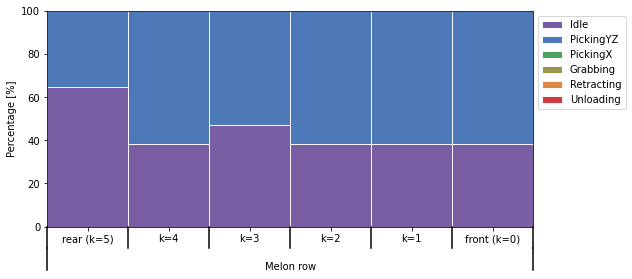

Saving 2D plot of the schedule ./plots/2dschedule.png


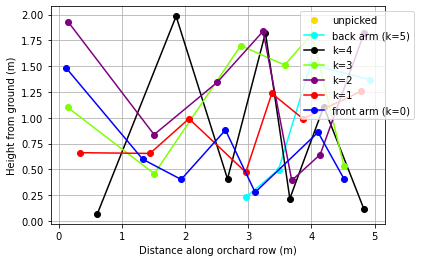

In [15]:
if __name__ == "__main__":
    # Base model
    printScen("Solving base scenario model")
    
    total_arms = n_arm * n_row
    
    FPT = 0
    solution_found = 0 # changes to 1 if at least one solution fits desired min values
    
    start_timer = datetime.now() # to figure out how looping through v_vy compares to pure MIP
    
    for v_vy_curr in v_vy_cmps_try:
        fruit_picked_by_curr = solve_melon_mip(arm, fruit, v_vy_curr)
        
        v_vy_mps = v_vy_curr / 100 # change to m/s
        
        total_picked = np.sum(curr_j)
        curr_FPE = (total_picked / numFruit)
        curr_FPT = total_picked / (travel_l / v_vy_mps)
        
        print()
        print('FPE:', curr_FPE*100, '%, and FPT:', curr_FPT, 'fruit/s') 
        print('when v_vy set at', v_vy_mps, 'm/s')
        print()            
        print('A total of', total_picked, 'fruits were harvested out of', numFruit)
        print('How many fruit were picked by each arm: *front* ', curr_j, ' *back*, fruit')
        print()

        if curr_FPE >= FPE_min:
            if curr_FPT > FPT:
                
                solution_found = 1
                
                FPE      = curr_FPE
                FPT      = curr_FPT
                v_vy     = v_vy_mps
                chosen_j = np.copy(curr_j)   # save the curr_j variable for the chosen run
                fruit_picked_by = fruit_picked_by_curr.copy() # copy the chosen run's fruit picked by list
            
        curr_j = np.zeros([n_row, n_arm]) # reset so that the next run does not keep adding into the variable
        
        print('########################### END RUN ###########################')
        print()
    
    print('########################## END LOOP ###########################')
    print()
    print('Looping through v_vy values took:', datetime.now()-start_timer, 'h:m:s')
    print()
    print('###############################################################')
    print()
    
    
#     v_vy = v_vy_cmps / 100 # change to m/s
#     solve_melon_mip_read()

    if solution_found == 1:
        print()
        print('chosen velocity {:.3f} m/s'.format(v_vy)) 
        print('Number of fruit picked by each arm: *front* ', chosen_j, ' *back*, fruit')
        print('FPE, {:.3f}%'.format(FPE*100), ', and FPT {:.3f}'.format(FPT))   
        print()
        print('A total of', total_picked, 'fruits were harvested out of', numFruit)
        print()

    #     print('Sorted fruit list')
    #     print(sortedFruit)

        # list for when there are multiple snapshots over the length of travel
        snapshot_list = list()
        snapshot_cell = list()

        # calculate how long each arm was working vs idle
        state_time = calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td)

        # fill in snapshot object and list with current results
        snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, chosen_j, sortedFruit, fruit_picked_by, state_time)
        snapshot_list.append(snapshot)
        ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)

        horizon_indexes = getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l)
        print(horizon_indexes)

        ## calculate multiple R and v_vy values based on multiple slices of the current view
        # return a list of fruit densities in each cell
        d = calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit)
        # print()
        ## I wonder if calculating the max number of fruit in a bunch would help...

        ## using the fruit densities, determine the vehicle speed to set a specific R value?
        # currently, the R value would be 
        R = calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

        snapshot_cell.append([d, R])

        # # combine the results based on the various snapshots taken
        results = IG_data_analysis(snapshot_list, snapshot_cell, travel_l, y_lim, set_algorithm, print_out)
        if print_out == 1:
            results.printSettings()

    #     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
        results.avgFPTandFPE()
        # results.avgPCT()
        # print()
        # results.plotValuesOverDistance()
        if plot_out == 1:
            results.plotTotalStatePercent()

            snapshot_schedules_2_plot = range(n_snapshots)  
            results.plot2DSchedule(snapshot_schedules_2_plot)